In [1]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV  
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.pipeline import make_pipeline
from scipy.stats import norm 
import keras.backend as Kb
import tensorflow as tf
from keras.layers import Dense, Input, Activation, Multiply
from keras.callbacks import LearningRateScheduler
from keras.models import Model
from keras.layers import Layer
from keras.initializers import VarianceScaling
from keras.regularizers import l2 as regularizers_l2
from tensorflow.python import keras
from sklearn.metrics import mean_absolute_error as mae
import time

import warnings
warnings.filterwarnings('ignore')

from platform import python_version

print(python_version())
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

3.8.5
TensorFlow version: 2.8.0
Keras version: 2.6.0


### Building differential neural network

In [7]:
import gc

gc.collect()
Kb.clear_session()

class DiffLayer(Layer):

    def __init__(self, inputLayer, outputDim, **kwargs):
      self.output_dim = outputDim
      self.inputLayer = inputLayer
      super(DiffLayer, self).__init__(**kwargs)

    def build(self, inputShape):
      # Create a trainable weight variable for this layer.
      self.kernel = Kb.transpose(self.inputLayer.kernel)
      super(DiffLayer, self).build(inputShape)  # Be sure to call this somewhere!

    def call(self, x):
      return Kb.dot(x, self.kernel)

    def computeOutputShape(self, inputShape):
      return (inputShape[0], self.outputDim)

def createNeuralNetwork(nLayers,units,inputDim):
  reg_strength = 0.000 

  #Input layer
  inputs = Input(shape=(inputDim,))

  #First hidden layer
  layer1 = Dense(units, kernel_initializer=VarianceScaling(), kernel_regularizer=regularizers_l2(l=reg_strength)) #when activation is not specified, the identity is used
  #https://androidkt.com/kernel-bias-and-activity-layer-weight-regularizers-keras/
  z1 = layer1(inputs) #as a^0=x
  hiddenLayers = [layer1]
  hiddenZ = [z1]

  if nLayers > 1:
    for n in range(nLayers-1):
      tempA = Activation("softplus")(hiddenZ[-1])
      tempLayer = Dense(units, kernel_initializer=VarianceScaling(), kernel_regularizer=regularizers_l2(l=reg_strength))
      tempZ = tempLayer(tempA)
      hiddenLayers.append(tempLayer)
      hiddenZ.append(tempZ)

  #Output layer (price layer)
  outputA = Activation("softplus")(hiddenZ[-1])
  priceLayer = Dense(1, name = 'Price_output', kernel_initializer=VarianceScaling(), kernel_regularizer = regularizers_l2(l=reg_strength))
  price = priceLayer(outputA)

  #First differential layer
  diffTerm = Activation("sigmoid")(hiddenZ[-1]) #As sigmoid is the derivative of Softplus
  firstTerm = Kb.transpose(priceLayer.kernel) #As y_bar=1 and not equal to price, before Kb.dot(price,Kb.transpose(price_layer.kernel))
  dif1 = Multiply()([diffTerm,firstTerm])
  difLayers = [dif1]

  if nLayers > 1:
    for i in range(nLayers-1):
      tempDiffTerm = Activation("sigmoid")(hiddenZ[-i-2])
      tempFirstTerm = DiffLayer(hiddenLayers[-i-1],units)(difLayers[-1]) 
      tempDif = Multiply()([tempDiffTerm,tempFirstTerm])
      difLayers.append(tempDif)

  delta = DiffLayer(hiddenLayers[0],1)(difLayers[-1])

  model = Model(inputs=[inputs], outputs=[price, delta])
  
  return model

#### Building differential polynomial regression

In [4]:
def DifferentialRegression(d,x,y,z,x_test,w):
    polynomial_features = PolynomialFeatures(degree=d, include_bias=True)
    phi = polynomial_features.fit_transform(x)
    powers = polynomial_features.powers_
    deltaphi = phi[:,:,np.newaxis] * powers / (x[:,np.newaxis,:] + epsilon) #NaN arise if epsilon is omitted
    phiTphi = np.tensordot(deltaphi,deltaphi,axes=([0,2],[0,2]))
    phiTz = np.tensordot(deltaphi,z,axes=([0,2],[0,1])).reshape(-1,1)
    det = round(np.linalg.det(w * np.dot(phi.T,phi) + (1-w) * phiTphi),50)
    if det == 0:
        result = print("Matrix is singular with determinant", det, "rounded to nearest 25 decimals")
    else:
        firstTerm = np.linalg.pinv((w * np.dot(phi.T,phi) + (1-w) * phiTphi))
        secondTerm = w * np.dot(phi.T,y) + (1-w) * phiTz
        beta = np.dot(firstTerm,secondTerm).reshape(-1, 1)
        phi_test = polynomial_features.transform(x_test)
        deltaphi_test = phi_test[:,:,np.newaxis] * powers / (x_test[:,np.newaxis,:] + epsilon)
        y_hat = np.dot(phi_test,beta)
        z_hat = np.tensordot(deltaphi_test,beta,axes=([1,0])).reshape(deltaphi_test.shape[0],-1)
        result = beta, y_hat.reshape(-1, 1), z_hat.reshape(-1, 1)
    return result

### Market models (Bachelier and Black-Scholes) and Data Normalization (One dimension)

In [4]:
def GenerateDataBachelier(nSim, K, sigma, spot, sigma0, T, seed): #T is time to maturity
    np.random.seed(seed)
    
    T0 = 1
    
    s0 = spot + sigma0 * np.sqrt(T0) * np.random.normal(size=nSim)
    sT = s0 + sigma * np.sqrt(T) * np.random.normal(size=nSim)
    
    payoff = np.maximum(0, sT - K)
    deriv = np.where(sT > K, 1, 0) 
    
    return s0, payoff, deriv

def Bachelier(S, K, sigma, T, greek):
    d = (S - K) / (sigma * np.sqrt(T))
    
    if greek == 0:
        val = sigma * np.sqrt(T) * norm.pdf(d) + (S - K) * norm.cdf(d)
        return val
    elif greek == 1: 
        delta = norm.cdf(d) #delta
        return delta
    else:
        return 0

def GenerateDataBlackScholes(nSim, K, sigma, spot, sigma0, T, seed): #T is time to maturity
    np.random.seed(seed)
    
    T0 = 1
    
    s0 = spot * np.exp((-0.5*sigma0*sigma0) * T0 + sigma0*np.sqrt(T0)*np.random.normal(size=nSim))
    sT = s0 * np.exp((-0.5*sigma*sigma) * T + sigma*np.sqrt(T)*np.random.normal(size=nSim))
    
    payoff = np.maximum(0, sT - K)
    deriv = np.where(sT > K, sT / s0, 0) 
    
    return s0, payoff, deriv

def BlackScholes(S, K, sigma, T, greek):
    d1 = (np.log(S/K) + 0.5 * sigma * sigma * T) / sigma / np.sqrt(T)
    d2 = d1 - sigma * np.sqrt(T)
    
    if greek == 0:
        val = S * norm.cdf(d1) - K * norm.cdf(d2)
        return val
    elif greek == 1: #delta
        delta = norm.cdf(d1)
        return delta
    else:
        return 0
       
def Normalization(X,payoffY,difY):
    Y = np.column_stack((payoffY,difY))   # training works best in normalized space, so we normalized our inputs and labels 
    meanX = np.mean(X,axis = 0)
    stdX = np.std(X,axis = 0)
    meanY = np.array([np.mean(payoffY),0])
    stdY = np.std(payoffY) * np.array([1,1/stdX])
    
    normX = (X - meanX) / stdX
    normY = (Y - meanY) / stdY
    
    return normX, meanX, stdX, normY, meanY, stdY

### Functions for plots and error measures 

In [6]:
def plot_ModelVSTruePricesNN(modelNN, testData, K, vol, TimeTMat, model):   
    if model == "BS":
        truePrices = BlackScholes(testData, K, vol, TimeTMat, 0)
    elif model == "B":
        truePrices = Bachelier(testData, K, vol, TimeTMat, 0)
    else:
        0
    predPrices = (modelNN.predict((testData - meanX) / stdX)[0] * stdY[0] + meanY[0])

    fig, ax = plt.subplots()
    ax.set_xlim(0.01,1.80)
    ax.set_ylim(-0.1,1.0) 
    ax.plot(trainX, trainPY,'o', markersize=1,label = "Simulated Payoffs",color = 'gray', alpha=0.5)
    ax.plot(testData, truePrices, '-',label = 'True Price',linewidth = 2, color="black")
    ax.plot(testData, predPrices, '--', label = 'Predicted Price (NN)', linewidth = 2,color = "red")
    ax.legend(loc = 'upper left',fontsize = 10)
    ax.set_xlabel('Spot',fontsize = 12)
    ax.set_ylabel('Call price',fontsize = 12)
    plt.savefig('{model}NNPrice.png'.format(model=model))
    plt.show(fig)
    
def plot_ModelVSTrueDeltasNN(modelNN,testData, K, vol, TimeTMat, model):
    if model == "BS":
        trueDelta = BlackScholes(testData, K, vol, TimeTMat, 1)
    elif model == "B":
        trueDelta = Bachelier(testData, K, vol, TimeTMat, 1)
    else:
        0 
    predDelta = (modelNN.predict((testData - meanX) / stdX)[1] * stdY[0] / stdX)
    
    fig, ax = plt.subplots()
    ax.set_xlim(0.20,1.80)
    ax.set_ylim(-0.1,1.2)
    ax.plot(testData, trueDelta, '-',label = 'True Delta',linewidth = 2, color="black")
    ax.plot(testData, predDelta, '--', label = 'Predicted Delta (NN)', linewidth = 2,color = "red")
    ax.legend(loc = 'upper left',fontsize = 10)
    ax.set_xlabel('Spot',fontsize = 12)
    ax.set_ylabel('Call delta',fontsize = 12)
    plt.savefig('{model}NNDelta.png'.format(model=model))
    plt.show(fig)
    
def mseErrorSample(K, vol, TimeTMat, model, diff):
    if model == "BS":
        truePrice =  BlackScholes(normX*stdX + meanX, K, vol, TimeTMat, 0)
        trueDelta =  BlackScholes(normX*stdX + meanX, K, vol, TimeTMat, 1)
    elif model == "B":
        truePrice = Bachelier(normX*stdX + meanX, K, vol, TimeTMat, 0)
        trueDelta = Bachelier(normX*stdX + meanX, K, vol, TimeTMat, 1)
    else:
        0
    samplePayoff = normY[:,0]*stdY[0]+meanY[0]
    sampleDelta = normY[:,1]*stdY[1]+meanY[1]
    if diff == "Y":
        mseErrorSample = 0.5 * np.mean((samplePayoff - truePrice)**2) + 0.5 * np.mean((sampleDelta - trueDelta)**2)
    elif diff == "N":
        mseErrorSample = np.mean((samplePayoff - truePrice)**2)
    else:
        0  
    return(mseErrorSample)

def errorPrice(modelNN,testData, K, vol, TimeTMat, model):
    if model == "BS":
        truePrice = BlackScholes(testData, K, vol, TimeTMat, 0)
    elif model == "B":
        truePrice = Bachelier(testData, K, vol, TimeTMat, 0)
    else:
        0    
    predPrice = (modelNN.predict((testData - meanX) / stdX)[0] * stdY[0] + meanY[0])[:,0]
    msePrice = np.mean((predPrice - truePrice)**2)    
    rmsePrice = np.sqrt(msePrice)
    maePrice = mae(truePrice, predPrice)
    return(msePrice, rmsePrice, maePrice)

def errorDelta(modelNN,testData, K, vol, TimeTMat, model):
    if model == "BS":
        trueDelta =  BlackScholes(testData, K, vol, TimeTMat, 1)
    elif model == "B":
        trueDelta =  Bachelier(testData, K, vol, TimeTMat, 1)
    else:
        0  
    predDelta = (modelNN.predict((testData - meanX) / stdX)[1] * stdY[0] / stdX)[:,0]
    mseDelta = np.mean((predDelta - trueDelta)**2)
    rmseDelta = np.sqrt(mseDelta)
    maeDelta = mae(trueDelta, predDelta)
    return(mseDelta, rmseDelta, maeDelta)
 

### Classic machine learning models for Bachelier (4x20 neural network and 7th degree polynomial regression)

In [12]:
#Option parameters
TimeToMat = 1
K = 1
vol = 0.2
ModelArch = (5,20) #Note that "number of layers" represents both the hidden layers AND the output layer
nSim = 30000
d = 7
w = 1
epsilon = 1.0e-08
seed = np.random.seed(2022)
xAxis = np.linspace(0.01, 1.80, 10000)

t0 = time.time()

#Simulate dataset
trainX, trainPY, trainDY = GenerateDataBachelier(nSim, K, vol, K, vol, TimeToMat, seed)
normX, meanX, stdX, normY, meanY, stdY = Normalization(trainX,trainPY,trainDY)
#mseBach = mseErrorSample(K, vol, TimeToMat, model="B", diff="N")
#mseBachDiff = mseErrorSample(K, vol, TimeToMat, model="B", diff="Y")

training time: 0.10741090774536133


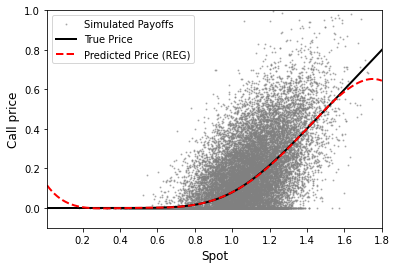

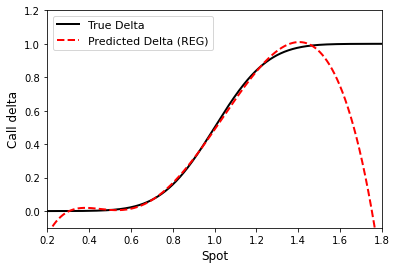

Sample MSE on true prices: 0.015364621234698048
Training loss: 0.015360781926173026
Validation loss: 0.027684906275397114
MSE Price: 0.0009615038129400094
MSE Delta: 0.11918138993067633
RMSE Price: 0.031008124950406297
RMSE Delta: 0.34522657767135534
MAE Price: 0.012750023183612716
MAE Delta: 0.16175498675687516


(None, None, None, None, None, None, None, None, None)

In [112]:
#Polynomial regression
xAxisReg=xAxis.reshape(-1,1)

testX, testPY, testDY = GenerateDataBachelier(7500, K, vol, K, vol, TimeTMat, seed)
truePrices = Bachelier(xAxisReg,K,vol,TimeToMat,greek=0)
trueDeltas = Bachelier(xAxisReg,K,vol,TimeToMat,greek=1)
samplePrices = Bachelier(trainX.reshape(-1,1),K,vol,TimeToMat,greek=0)
sampleDeltas = Bachelier(trainX.reshape(-1,1),K,vol,TimeToMat,greek=1)

t0=time.time()

predPrices = DifferentialRegression(d, trainX.reshape(-1,1), trainPY.reshape(-1,1), trainDY.reshape(-1,1), xAxisReg, w)[1]
predPricesTrain = DifferentialRegression(d, trainX.reshape(-1,1), trainPY.reshape(-1,1), trainDY.reshape(-1,1), trainX.reshape(-1,1), w)[1]
predPricesVal = DifferentialRegression(d, trainX.reshape(-1,1), trainPY.reshape(-1,1), trainDY.reshape(-1,1), testX.reshape(-1,1), w)[1]  
predDeltas = DifferentialRegression(d, trainX.reshape(-1,1), trainPY.reshape(-1,1), trainDY.reshape(-1,1), xAxisReg, w)[2]
predDeltasTrain = DifferentialRegression(d, trainX.reshape(-1,1), trainPY.reshape(-1,1), trainDY.reshape(-1,1), trainX.reshape(-1,1), w)[2]
predDeltasVal = DifferentialRegression(d, trainX.reshape(-1,1), trainPY.reshape(-1,1), trainDY.reshape(-1,1), testX.reshape(-1,1), w)[2]  

t1 = time.time()
print("training time:", t1-t0)
mseErrorSample = w*np.mean((samplePrices-trainPY.reshape(-1,1))**2)+(1-w)*np.mean((sampleDeltas-trainDY.reshape(-1,1))**2)
trainingLoss = w*np.mean((predPricesTrain-trainPY.reshape(-1,1))**2)+(1-w)*np.mean((predDeltasTrain-trainDY.reshape(-1,1))**2)
validationLoss = w*np.mean((predPricesVal-testPY)**2)+(1-w)*np.mean((predDeltasVal-testDY)**2)
msePriceError = np.mean((predPrices-truePrices)**2)
mseDeltaError = np.mean((predDeltas-trueDeltas)**2)
rmsePriceError = np.sqrt(msePriceError)
rmseDeltaError = np.sqrt(mseDeltaError)
maePriceError = mae(predPrices,truePrices)
maeDeltaError = mae(predDeltas,trueDeltas)
    
fig, ax = plt.subplots()
ax.set_xlim(0.01,1.80)
ax.set_ylim(-0.1,1.00) 
ax.plot(trainX.reshape(-1,1),trainPY.reshape(-1,1),'o', markersize=1,label = "Simulated Payoffs",color = 'gray', alpha=0.5) 
ax.plot(xAxisReg, truePrices, '-',label = 'True Price',linewidth = 2, color="black") 
ax.plot(xAxisReg, predPrices, '--', label = 'Predicted Price (REG)', linewidth = 2,color = "red") 
ax.legend(loc = 'upper left',fontsize = 10)
ax.set_xlabel('Spot',fontsize = 12)
ax.set_ylabel('Call price',fontsize = 12)
plt.show(fig)

fig1, ax1 = plt.subplots()
ax1.set_xlim(0.20,1.80)
ax1.set_ylim(-0.1,1.2)
ax1.plot(xAxis, trueDeltas, '-',label = 'True Delta',linewidth = 2, color="black") 
ax1.plot(xAxis, predDeltas, '--', label = 'Predicted Delta (REG)', linewidth = 2,color = "red") 
ax1.legend(loc = 'upper left',fontsize = 11)
ax1.set_xlabel('Spot',fontsize = 12)
ax1.set_ylabel('Call delta',fontsize = 12)
plt.show(fig1)
    
print("Sample MSE on true prices:", mseErrorSample), print("Training loss:", trainingLoss), print("Validation loss:", validationLoss), print("MSE Price:", msePriceError), print("MSE Delta:", mseDeltaError), print("RMSE Price:", rmsePriceError), print("RMSE Delta:", rmseDeltaError), print("MAE Price:", maePriceError), print("MAE Delta:", maeDeltaError)



/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Training time:  12.294381141662598


/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


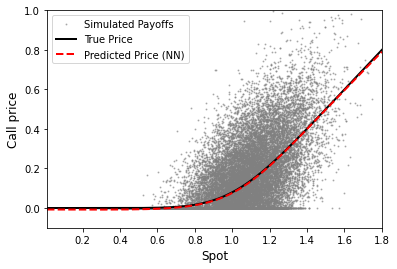

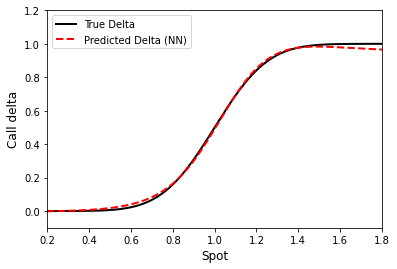

Sample MSE on true price:  0.015364621234698048
B MSE Test:  (2.8954387088041312e-05, 0.005380928087982715, 0.004878154921447927)
B MSE Delta Test:  (0.00016601279896848574, 0.012884595413457333, 0.00994082921134817)
Training loss:  0.015396638603816681
Validation loss 0.015099366088247978


In [113]:
#Neural network
testX, testPY, testDY = GenerateDataBachelier(7500, K, vol, K, vol, TimeToMat, seed)
testY = np.column_stack((testPY,testDY))
normTestX = (testX-meanX)/stdX
normTestY = (testY-meanY)/stdY

tf.keras.backend.clear_session()
t0 = time.time()
modelBach = createNeuralNetwork(ModelArch[0],ModelArch[1],1)
modelBach.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = 'mean_squared_error',loss_weights = [1,0])
history = modelBach.fit(normX, [normY[:,0],normY[:,1]], epochs = 100, batch_size = 1024, verbose = 0, validation_data = (normTestX, [normTestY[:,0],normTestY[:,1]]))

t1 = time.time()
print('Training time: ',t1-t0)

plot_ModelVSTruePricesNN(modelBach, xAxis, K, vol, TimeToMat, model="B")
plot_ModelVSTrueDeltasNN(modelBach, xAxis, K, vol, TimeToMat, model="B")
#print('Sample MSE on true price: ',mseBach)
print('B MSE Test: ',errorPrice(modelBach, xAxis, K, vol, TimeToMat, model="B"))
print('B MSE Delta Test: ',errorDelta(modelBach, xAxis, K, vol, TimeToMat, model="B"))
print('Training loss: ', history.history['Price_output_loss'][-1]*(stdY[0]**2))
print('Validation loss', history.history['val_Price_output_loss'][-1]*(stdY[0]**2))

### Differential machine learning models for Bachelier (3x20 neural network and 7th degree polynomial regression)

training time: 0.14149808883666992


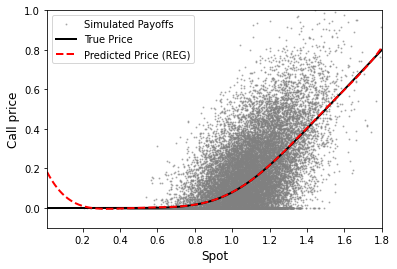

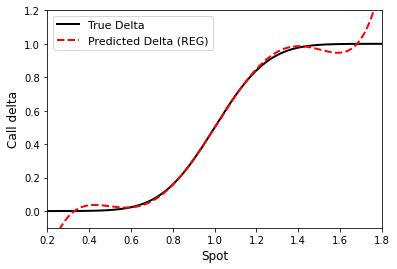

Sample MSE on true prices: 0.09023746870777513
Training loss: 0.09026168291817596
Validation loss: 0.1818139961118224
MSE Price: 0.0008213948586503668
MSE Delta: 0.11199169920092074
RMSE Price: 0.028659987066472426
RMSE Delta: 0.3346516086931613
MAE Price: 0.009301309785902451
MAE Delta: 0.12485101406103881


(None, None, None, None, None, None, None, None, None)

In [123]:
#Polynomial regression
w=0.5

testX, testPY, testDY = GenerateDataBachelier(7500, K, vol, K, vol, TimeTMat, seed)
truePrices = Bachelier(xAxisReg,K,vol,TimeToMat,greek=0)
trueDeltas = Bachelier(xAxisReg,K,vol,TimeToMat,greek=1)
samplePrices = Bachelier(trainX.reshape(-1,1),K,vol,TimeToMat,greek=0)
sampleDeltas = Bachelier(trainX.reshape(-1,1),K,vol,TimeToMat,greek=1)

t0=time.time()

predPrices = DifferentialRegression(d, trainX.reshape(-1,1), trainPY.reshape(-1,1), trainDY.reshape(-1,1), xAxisReg, w)[1]
predPricesTrain = DifferentialRegression(d, trainX.reshape(-1,1), trainPY.reshape(-1,1), trainDY.reshape(-1,1), trainX.reshape(-1,1), w)[1]
predPricesVal = DifferentialRegression(d, trainX.reshape(-1,1), trainPY.reshape(-1,1), trainDY.reshape(-1,1), testX.reshape(-1,1), w)[1]  
predDeltas = DifferentialRegression(d, trainX.reshape(-1,1), trainPY.reshape(-1,1), trainDY.reshape(-1,1), xAxisReg, w)[2]
predDeltasTrain = DifferentialRegression(d, trainX.reshape(-1,1), trainPY.reshape(-1,1), trainDY.reshape(-1,1), trainX.reshape(-1,1), w)[2]
predDeltasVal = DifferentialRegression(d, trainX.reshape(-1,1), trainPY.reshape(-1,1), trainDY.reshape(-1,1), testX.reshape(-1,1), w)[2]  

t1 = time.time()
print("training time:", t1-t0)
mseErrorSample = w*np.mean((samplePrices-trainPY.reshape(-1,1))**2)+(1-w)*np.mean((sampleDeltas-trainDY.reshape(-1,1))**2)
trainingLoss = w*np.mean((predPricesTrain-trainPY.reshape(-1,1))**2)+(1-w)*np.mean((predDeltasTrain-trainDY.reshape(-1,1))**2)
validationLoss = w*np.mean((predPricesVal-testPY)**2)+(1-w)*np.mean((predDeltasVal-testDY)**2)
msePriceError = np.mean((predPrices-truePrices)**2)
mseDeltaError = np.mean((predDeltas-trueDeltas)**2)
rmsePriceError = np.sqrt(msePriceError)
rmseDeltaError = np.sqrt(mseDeltaError)
maePriceError = mae(predPrices,truePrices)
maeDeltaError = mae(predDeltas,trueDeltas)
    
fig, ax = plt.subplots()
ax.set_xlim(0.01,1.80)
ax.set_ylim(-0.1,1.00) 
ax.plot(trainX.reshape(-1,1),trainPY.reshape(-1,1),'o', markersize=1,label = "Simulated Payoffs",color = 'gray', alpha=0.5) 
ax.plot(xAxisReg, truePrices, '-',label = 'True Price',linewidth = 2, color="black") 
ax.plot(xAxisReg, predPrices, '--', label = 'Predicted Price (REG)', linewidth = 2,color = "red") 
ax.legend(loc = 'upper left',fontsize = 10)
ax.set_xlabel('Spot',fontsize = 12)
ax.set_ylabel('Call price',fontsize = 12)
plt.show(fig)

fig1, ax1 = plt.subplots()
ax1.set_xlim(0.20,1.80)
ax1.set_ylim(-0.1,1.2)
ax1.plot(xAxis, trueDeltas, '-',label = 'True Delta',linewidth = 2, color="black") 
ax1.plot(xAxis, predDeltas, '--', label = 'Predicted Delta (REG)', linewidth = 2,color = "red") 
ax1.legend(loc = 'upper left',fontsize = 11)
ax1.set_xlabel('Spot',fontsize = 12)
ax1.set_ylabel('Call delta',fontsize = 12)
plt.show(fig1)
    
print("Sample MSE on true prices:", mseErrorSample), print("Training loss:", trainingLoss), print("Validation loss:", validationLoss), print("MSE Price:", msePriceError), print("MSE Delta:", mseDeltaError), print("RMSE Price:", rmsePriceError), print("RMSE Delta:", rmseDeltaError), print("MAE Price:", maePriceError), print("MAE Delta:", maeDeltaError)


Training time:  13.189902067184448


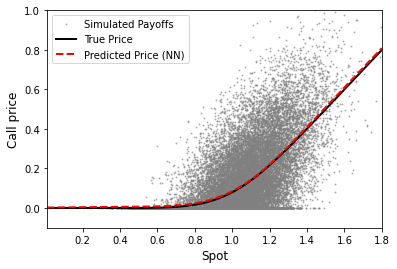

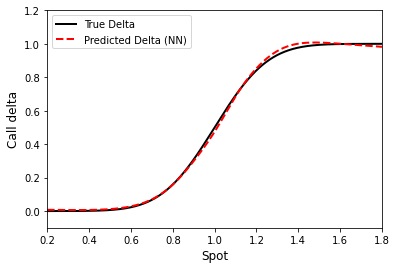

Sample MSE on true price:  0.09023746870777513
B MSE Test:  (4.777821922118415e-05, 0.006912179050139265, 0.006520444244602627)
B MSE Delta Test:  (0.0001569188866489646, 0.012526726892886449, 0.01019631649648188)
Training loss:  0.09024994887815321
Validation loss 0.09129314381868094


In [124]:
#Neural network using the optimal setting found in the hyperparameter searcg
ModelArch = (4,20)

testX, testPY, testDY = GenerateDataBachelier(7500, K, vol, K, vol, TimeToMat, seed)
testY = np.column_stack((testPY,testDY))
normTestX = (testX-meanX)/stdX
normTestY = (testY-meanY)/stdY

tf.keras.backend.clear_session()
t0 = time.time()
modelBachDiff = createNeuralNetwork(ModelArch[0],ModelArch[1],1)
modelBachDiff.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error',loss_weights = [0.5,0.5])
history = modelBachDiff.fit(normX, [normY[:,0],normY[:,1]], epochs = 100, batch_size = 1024, verbose = 0, validation_data = (normTestX, [normTestY[:,0],normTestY[:,1]]))

t1 = time.time()
print('Training time: ',t1-t0)

plot_ModelVSTruePricesNN(modelBachDiff, xAxis, K, vol, TimeToMat, model="B")
plot_ModelVSTrueDeltasNN(modelBachDiff, xAxis, K, vol, TimeToMat, model="B")
#print('Sample MSE on true price: ',mseBachDiff)
print('B MSE Test: ',errorPrice(modelBachDiff, xAxis, K, vol, TimeToMat, model="B"))
print('B MSE Delta Test: ',errorDelta(modelBachDiff, xAxis, K, vol, TimeToMat, model="B"))
print('Training loss: ', 0.5*history.history['Price_output_loss'][-1]*(stdY[0]**2)+0.5*history.history['diff_layer_3_loss'][-1]*(stdY[1]**2))
print('Validation loss', 0.5*history.history['val_Price_output_loss'][-1]*(stdY[0]**2)+0.5*history.history['val_diff_layer_3_loss'][-1]*(stdY[1]**2))

### Classic machine learning models for Black-Scholes (4x20 neural network and 7th degree polynomial regression)

In [127]:
#Option parameters
TimeToMat = 1
K = 1
vol = 0.2
ModelArch = (5,20) #Note that "number of layers" represents both the hidden layers AND the output layer
nSim = 30000
d = 7
w = 1
epsilon = 1.0e-08
seed = np.random.seed(1996)

t0 = time.time()

#Simulate dataset
trainX, trainPY, trainDY = GenerateDataBlackScholes(nSim, K, vol, K, vol, TimeToMat, seed)
normX, meanX, stdX, normY, meanY, stdY = Normalization(trainX,trainPY,trainDY)
#mseBS = mseErrorSample(K, vol, TimeToMat, model="BS", diff="N")
#mseBSDiff = mseErrorSample(K, vol, TimeToMat, model="BS", diff="Y")

training time: 0.148237943649292


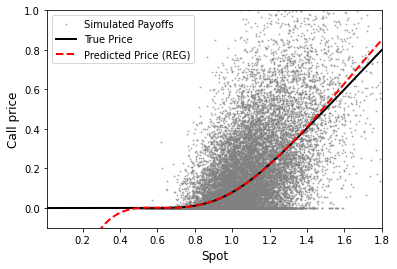

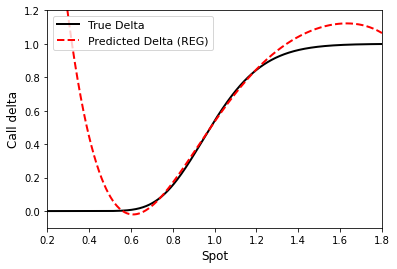

Sample MSE on true prices: 0.02324940633506132
Training loss: 0.023227014284356324
Validation loss: 0.03635662254549236
MSE Price: 0.04858514716481002
MSE Delta: 2.3683119852815824
RMSE Price: 0.22042038736199068
RMSE Delta: 1.5389320924854295
MAE Price: 0.08621586694238413
MAE Delta: 0.6469511946743219


(None, None, None, None, None, None, None, None, None)

In [128]:
#Polynomial regression
xAxisReg=xAxis.reshape(-1,1)

testX, testPY, testDY = GenerateDataBlackScholes(7500, K, vol, K, vol, TimeTMat, seed)
truePrices = BlackScholes(xAxisReg,K,vol,TimeToMat,greek=0)
trueDeltas = BlackScholes(xAxisReg,K,vol,TimeToMat,greek=1)
samplePrices = BlackScholes(trainX.reshape(-1,1),K,vol,TimeToMat,greek=0)
sampleDeltas = BlackScholes(trainX.reshape(-1,1),K,vol,TimeToMat,greek=1)

t0=time.time()

predPrices = DifferentialRegression(d, trainX.reshape(-1,1), trainPY.reshape(-1,1), trainDY.reshape(-1,1), xAxisReg, w)[1]
predPricesTrain = DifferentialRegression(d, trainX.reshape(-1,1), trainPY.reshape(-1,1), trainDY.reshape(-1,1), trainX.reshape(-1,1), w)[1]
predPricesVal = DifferentialRegression(d, trainX.reshape(-1,1), trainPY.reshape(-1,1), trainDY.reshape(-1,1), testX.reshape(-1,1), w)[1]  
predDeltas = DifferentialRegression(d, trainX.reshape(-1,1), trainPY.reshape(-1,1), trainDY.reshape(-1,1), xAxisReg, w)[2]
predDeltasTrain = DifferentialRegression(d, trainX.reshape(-1,1), trainPY.reshape(-1,1), trainDY.reshape(-1,1), trainX.reshape(-1,1), w)[2]
predDeltasVal = DifferentialRegression(d, trainX.reshape(-1,1), trainPY.reshape(-1,1), trainDY.reshape(-1,1), testX.reshape(-1,1), w)[2]  

t1 = time.time()
print("training time:", t1-t0)
mseErrorSample = w*np.mean((samplePrices-trainPY.reshape(-1,1))**2)+(1-w)*np.mean((sampleDeltas-trainDY.reshape(-1,1))**2)
trainingLoss = w*np.mean((predPricesTrain-trainPY.reshape(-1,1))**2)+(1-w)*np.mean((predDeltasTrain-trainDY.reshape(-1,1))**2)
validationLoss = w*np.mean((predPricesVal-testPY)**2)+(1-w)*np.mean((predDeltasVal-testDY)**2)
msePriceError = np.mean((predPrices-truePrices)**2)
mseDeltaError = np.mean((predDeltas-trueDeltas)**2)
rmsePriceError = np.sqrt(msePriceError)
rmseDeltaError = np.sqrt(mseDeltaError)
maePriceError = mae(predPrices,truePrices)
maeDeltaError = mae(predDeltas,trueDeltas)
    
fig, ax = plt.subplots()
ax.set_xlim(0.01,1.80)
ax.set_ylim(-0.1,1.00) 
ax.plot(trainX.reshape(-1,1),trainPY.reshape(-1,1),'o', markersize=1,label = "Simulated Payoffs",color = 'gray', alpha=0.5) 
ax.plot(xAxisReg, truePrices, '-',label = 'True Price',linewidth = 2, color="black") 
ax.plot(xAxisReg, predPrices, '--', label = 'Predicted Price (REG)', linewidth = 2,color = "red") 
ax.legend(loc = 'upper left',fontsize = 10)
ax.set_xlabel('Spot',fontsize = 12)
ax.set_ylabel('Call price',fontsize = 12)
#plt.savefig('B1Price.png')
plt.show(fig)

fig1, ax1 = plt.subplots()
ax1.set_xlim(0.20,1.80)
ax1.set_ylim(-0.1,1.2)
ax1.plot(xAxis, trueDeltas, '-',label = 'True Delta',linewidth = 2, color="black") 
ax1.plot(xAxis, predDeltas, '--', label = 'Predicted Delta (REG)', linewidth = 2,color = "red") 
ax1.legend(loc = 'upper left',fontsize = 11)
ax1.set_xlabel('Spot',fontsize = 12)
ax1.set_ylabel('Call delta',fontsize = 12)
plt.savefig('B1Delta.png')
plt.show(fig1)
    
print("Sample MSE on true prices:", mseErrorSample), print("Training loss:", trainingLoss), print("Validation loss:", validationLoss), print("MSE Price:", msePriceError), print("MSE Delta:", mseDeltaError), print("RMSE Price:", rmsePriceError), print("RMSE Delta:", rmseDeltaError), print("MAE Price:", maePriceError), print("MAE Delta:", maeDeltaError)




Training time:  23.90478229522705


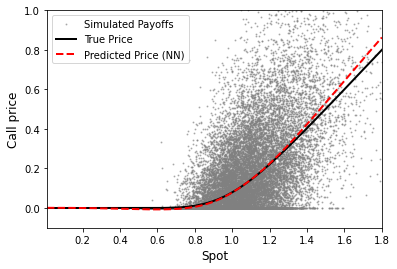

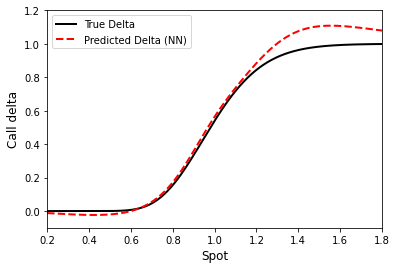

B MSE Test:  (0.0009113835939367391, 0.030189130393847702, 0.018599734293741833)
B MSE Delta Test:  (0.0037072261285593386, 0.0608869947407436, 0.04607687458218899)
Training loss:  0.023396873205511523
Validation loss 0.003712926549979323


In [129]:
testX, testPY, testDY = GenerateDataBlackScholes(7500, K, vol, K, vol, TimeTMat, seed)
testY = np.column_stack((testPY,testDY))
normTestX = (testX-meanX)/stdX
normTestY = (testY-meanY)/stdY

tf.keras.backend.clear_session()
t0 = time.time()
modelBS = createNeuralNetwork(ModelArch[0],ModelArch[1],1)
modelBS.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = 'mean_squared_error',loss_weights = [1,0])
history = modelBS.fit(normX, [normY[:,0],normY[:,1]], epochs = 100, batch_size = 1024, verbose = 0, validation_data = (normTestX, [normTestY[:,0],normTestY[:,1]]))
t1 = time.time()
print('Training time: ',t1-t0)
    
xAxis = np.linspace(0.01, 1.80, 10000)

plot_ModelVSTruePricesNN(modelBS, xAxis, K, vol, TimeToMat, model="BS")
plot_ModelVSTrueDeltasNN(modelBS, xAxis, K, vol, TimeToMat, model="BS")
#print('Sample MSE on true price: ',mseBS)
print('B MSE Test: ',errorPrice(modelBS, xAxis, K, vol, TimeToMat, model="BS"))
print('B MSE Delta Test: ',errorDelta(modelBS, xAxis, K, vol, TimeToMat, model="BS"))
print('Training loss: ', history.history['Price_output_loss'][-1]*(stdY[0]**2))
print('Validation loss', history.history['val_Price_output_loss'][-1]*(stdY[0]**2))

### Differential machine learning models for Black-Scholes (3x20 neural network and 7th degree polynomial regression)

training time: 0.08099198341369629


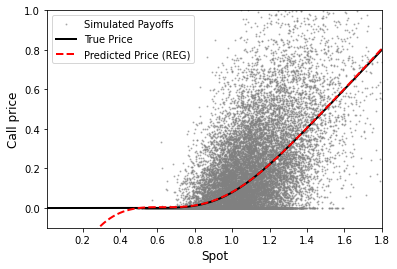

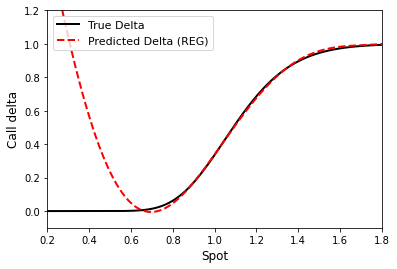

Sample MSE on true prices: 0.13442399581819742
Training loss: 0.13443531113310686
Validation loss: 0.18985733281513423
MSE Price: 0.018959563487102364
MSE Delta: 0.6160137966907733
RMSE Price: 0.13769373074727245
RMSE Delta: 0.7848654640706095
MAE Price: 0.05406764888695251
MAE Delta: 0.3529720798321569


(None, None, None, None, None, None, None, None, None)

In [130]:
#Polynomial regression
w=0.5

testX, testPY, testDY = GenerateDataBlackScholes(7500, K, vol, K, vol, TimeTMat, seed)
truePrices = BlackScholes(xAxisReg,K,vol,TimeToMat,greek=0)
trueDeltas = BlackScholes(xAxisReg,K,vol,TimeToMat,greek=1)
samplePrices = BlackScholes(trainX.reshape(-1,1),K,vol,TimeToMat,greek=0)
sampleDeltas = BlackScholes(trainX.reshape(-1,1),K,vol,TimeToMat,greek=1)

t0=time.time()

predPrices = DifferentialRegression(d, trainX.reshape(-1,1), trainPY.reshape(-1,1), trainDY.reshape(-1,1), xAxisReg, w)[1]
predPricesTrain = DifferentialRegression(d, trainX.reshape(-1,1), trainPY.reshape(-1,1), trainDY.reshape(-1,1), trainX.reshape(-1,1), w)[1]
predPricesVal = DifferentialRegression(d, trainX.reshape(-1,1), trainPY.reshape(-1,1), trainDY.reshape(-1,1), testX.reshape(-1,1), w)[1]  
predDeltas = DifferentialRegression(d, trainX.reshape(-1,1), trainPY.reshape(-1,1), trainDY.reshape(-1,1), xAxisReg, w)[2]
predDeltasTrain = DifferentialRegression(d, trainX.reshape(-1,1), trainPY.reshape(-1,1), trainDY.reshape(-1,1), trainX.reshape(-1,1), w)[2]
predDeltasVal = DifferentialRegression(d, trainX.reshape(-1,1), trainPY.reshape(-1,1), trainDY.reshape(-1,1), testX.reshape(-1,1), w)[2]  

t1 = time.time()
print("training time:", t1-t0)
mseErrorSample = w*np.mean((samplePrices-trainPY.reshape(-1,1))**2)+(1-w)*np.mean((sampleDeltas-trainDY.reshape(-1,1))**2)
trainingLoss = w*np.mean((predPricesTrain-trainPY.reshape(-1,1))**2)+(1-w)*np.mean((predDeltasTrain-trainDY.reshape(-1,1))**2)
validationLoss = w*np.mean((predPricesVal-testPY)**2)+(1-w)*np.mean((predDeltasVal-testDY)**2)
msePriceError = np.mean((predPrices-truePrices)**2)
mseDeltaError = np.mean((predDeltas-trueDeltas)**2)
rmsePriceError = np.sqrt(msePriceError)
rmseDeltaError = np.sqrt(mseDeltaError)
maePriceError = mae(predPrices,truePrices)
maeDeltaError = mae(predDeltas,trueDeltas)
    
fig, ax = plt.subplots()
ax.set_xlim(0.01,1.80)
ax.set_ylim(-0.1,1.00) 
ax.plot(trainX.reshape(-1,1),trainPY.reshape(-1,1),'o', markersize=1,label = "Simulated Payoffs",color = 'gray', alpha=0.5) 
ax.plot(xAxisReg, truePrices, '-',label = 'True Price',linewidth = 2, color="black") 
ax.plot(xAxisReg, predPrices, '--', label = 'Predicted Price (REG)', linewidth = 2,color = "red") 
ax.legend(loc = 'upper left',fontsize = 10)
ax.set_xlabel('Spot',fontsize = 12)
ax.set_ylabel('Call price',fontsize = 12)
#plt.savefig('B1Price.png')
plt.show(fig)

fig1, ax1 = plt.subplots()
ax1.set_xlim(0.20,1.80)
ax1.set_ylim(-0.1,1.2)
ax1.plot(xAxis, trueDeltas, '-',label = 'True Delta',linewidth = 2, color="black") 
ax1.plot(xAxis, predDeltas, '--', label = 'Predicted Delta (REG)', linewidth = 2,color = "red") 
ax1.legend(loc = 'upper left',fontsize = 11)
ax1.set_xlabel('Spot',fontsize = 12)
ax1.set_ylabel('Call delta',fontsize = 12)
plt.savefig('B1Delta.png')
plt.show(fig1)
    
print("Sample MSE on true prices:", mseErrorSample), print("Training loss:", trainingLoss), print("Validation loss:", validationLoss), print("MSE Price:", msePriceError), print("MSE Delta:", mseDeltaError), print("RMSE Price:", rmsePriceError), print("RMSE Delta:", rmseDeltaError), print("MAE Price:", maePriceError), print("MAE Delta:", maeDeltaError)

Training time:  14.452248096466064


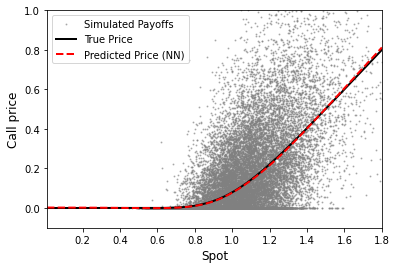

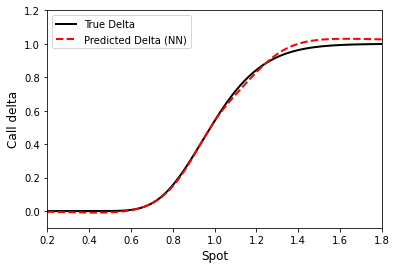

B MSE Test:  (1.605140215740308e-05, 0.004006420117436897, 0.0029302469064163843)
B MSE Delta Test:  (0.00040187270034692277, 0.020046762839593897, 0.014514348369823474)
Training loss:  0.13466189639707654
Validation loss 0.055948446380139856


In [132]:
ModelArch = (4,20)

testX, testPY, testDY = GenerateDataBlackScholes(7500, K, vol, K, vol, TimeTMat, seed)
testY = np.column_stack((testPY,testDY))
normTestX = (testX-meanX)/stdX
normTestY = (testY-meanY)/stdY

tf.keras.backend.clear_session()
t0 = time.time()
modelBSDiff = createNeuralNetwork(ModelArch[0],ModelArch[1],1)
modelBSDiff.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error',loss_weights = [0.5,0.5])
history = modelBSDiff.fit(normX, [normY[:,0],normY[:,1]], epochs = 100, batch_size = 1024, verbose = 0, validation_data = (normTestX, [normTestY[:,0],normTestY[:,1]]))
t1 = time.time()
print('Training time: ',t1-t0)
    
xAxis = np.linspace(0.01, 1.80, 10000)

plot_ModelVSTruePricesNN(modelBSDiff, xAxis, K, vol, TimeToMat, model="BS")
plot_ModelVSTrueDeltasNN(modelBSDiff, xAxis, K, vol, TimeToMat, model="BS")
#print('Sample MSE on true price: ',mseBS)
print('B MSE Test: ',errorPrice(modelBSDiff, xAxis, K, vol, TimeToMat, model="BS"))
print('B MSE Delta Test: ',errorDelta(modelBSDiff, xAxis, K, vol, TimeToMat, model="BS"))
print('Training loss: ', 0.5*history.history['Price_output_loss'][-1]*(stdY[0]**2)+0.5*history.history['diff_layer_3_loss'][-1]*(stdY[1]**2))
print('Validation loss', 0.5*history.history['val_Price_output_loss'][-1]*(stdY[0]**2)+0.5*history.history['val_diff_layer_3_loss'][-1]*(stdY[1]**2))

### Discrete delta-hedging strategy for Bachelier

In [166]:
#Simulating stock path

def pathsBachelier(T,K,sigma,nPaths,nSteps):
    dt=T/nSteps
    np.random.randint(8192)
    pathsStock = np.zeros([nPaths,nSteps+1])
    s0 = K 
    pathsStock[:,0] = s0
    for t in range(0,nSteps):
        pathsStock[:,t+1] = pathsStock[:,t] + sigma * np.sqrt(dt) * np.random.normal(size=nPaths)
    return pathsStock

In [ ]:
#Neural networks
sigma = sigma0 = 0.2
K = spot = 1 
T = 1
d = np.array([0, 2, 3, 4, 5, 6]) 
nSteps=52
nPaths= 1000
#nSim= 100
seed = np.random.randint(8192)
dt=T/nSteps
times=np.arange(0,T+0.01,dt) 

L = np.array([500, 1000, 2000, 3000, 4000, 5000, 6000, 10000, 30000])

stdFinalBankBalanceMatrix=np.zeros([len(L),len(d)])
stdFinalBankBalanceMatrix_Diff=np.zeros([len(L),len(d)])
stockPath = pathsBachelier(T,K,sigma,nPaths,nSteps)
for j in range(0,len(d)):
    t0=time.time()
    dim=d[j]
    stdFinalBankBalance = np.zeros(len(L))
    stdFinalBankBalance_Diff = np.zeros(len(L))
    for i in range(0,len(L)):
        nSim = L[i]
        s0=stockPath[:,0].reshape(nPaths, -1)
        seed = np.random.randint(8192)
        if dim==0:
            z_pred = z_pred_Diff = Bachelier(s0, K, sigma, T, greek=1)
        else:
            tf.keras.backend.clear_session()
            trainX, trainPY, trainDY = GenerateDataBachelier(nSim, K, sigma, spot, sigma0, T, seed)
            normX, meanX, stdX, normY, meanY, stdY = Normalization(trainX,trainPY,trainDY)            
            model_size = (dim,20) #the first input represents the number of layers and the second is the number of units
            model_diff = createNeuralNetwork(model_size[0],model_size[1],1)
            model_diff.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error',loss_weights = [0.5,0.5])
            model_diff.fit(normX, [normY[:,0],normY[:,1]], epochs = 100, batch_size = 1024, verbose = 0)
            z_pred_Diff = (model_diff.predict((s0 - meanX) / stdX)[1] * stdY[0] / stdX)
            tf.keras.backend.clear_session()
            model_ord = createNeuralNetwork(model_size[0],model_size[1],1)
            model_ord.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error',loss_weights = [1,0])
            model_ord.fit(normX, [normY[:,0],normY[:,1]], epochs = 100, batch_size = 1024, verbose = 0)
            z_pred = (model_ord.predict((s0 - meanX) / stdX)[1] * stdY[0] / stdX)
        stockQuantity = z_pred #delta, a
        stockQuantity_Diff = z_pred_Diff
        cost = stockQuantity*s0
        cost_Diff = stockQuantity_Diff*s0
        chargeToCustomer = Bachelier(s0, K, sigma, T-times[0], greek=0)
        bankBalance = chargeToCustomer - cost
        bankBalance_Diff = chargeToCustomer - cost_Diff
        #initialPrice = chargeToCustomer
        for t in range(1,nSteps):
            S = stockPath[:,t].reshape(nPaths, -1)
            timeToMaturity = T-times[t]
            seed = np.random.randint(8192)
            if dim==0:
                z_pred = z_pred_Diff = Bachelier(S, K, sigma, timeToMaturity, greek=1)
            else:
                tf.keras.backend.clear_session()
                trainX, trainPY, trainDY = GenerateDataBachelier(nSim, K, sigma, spot, sigma0, timeToMaturity, seed)
                normX, meanX, stdX, normY, meanY, stdY = Normalization(trainX,trainPY,trainDY)            
                model_size = (dim,20) #the first input represents the number of layers and the second is the number of units
                model_diff = createNeuralNetwork(model_size[0],model_size[1],1)
                model_diff.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error',loss_weights = [0.5,0.5])
                model_diff.fit(normX, [normY[:,0],normY[:,1]], epochs = 100, batch_size = 1024, verbose = 0)
                z_pred_Diff = (model_diff.predict((S - meanX) / stdX)[1] * stdY[0] / stdX)
                model_ord = createNeuralNetwork(model_size[0],model_size[1],1)
                model_ord.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error',loss_weights = [1,0])
                model_ord.fit(normX, [normY[:,0],normY[:,1]], epochs = 100, batch_size = 1024, verbose = 0)
                z_pred = (model_ord.predict((S - meanX) / stdX)[1] * stdY[0] / stdX)
            #z_pred = Bachelier(S, K, sigma, timeToMaturity, greek=1) #BachelierDeltaCall(S, K, sigma, timeToMaturity) #BlackScholesDelta(s, K, sigma, timeToMaturity)
            newStockQuantity = z_pred
            newStockQuantity_Diff = z_pred_Diff
            amountToBuy = newStockQuantity-stockQuantity
            amountToBuy_Diff = newStockQuantity_Diff-stockQuantity_Diff
            cost = amountToBuy*S
            cost_Diff = amountToBuy_Diff*S
            bankBalance=bankBalance-cost
            bankBalance_Diff=bankBalance_Diff-cost_Diff
            stockQuantity = newStockQuantity
            stockQuantity_Diff = newStockQuantity_Diff
        S = stockPath[:,nSteps].reshape(nPaths, -1)
        stockValue = stockQuantity*S
        stockValue_Diff = stockQuantity_Diff*S
        liability = np.maximum(S-K,0)
        bankBalance = (bankBalance + stockValue - liability)
        bankBalance_Diff = (bankBalance_Diff + stockValue_Diff - liability)
        finalBankBalance = bankBalance
        finalBankBalance_Diff = bankBalance_Diff
        stdFinalBankBalance[i] = np.std(finalBankBalance)
        stdFinalBankBalance_Diff[i] = np.std(finalBankBalance_Diff)
    stdFinalBankBalanceMatrix[:,j]=stdFinalBankBalance/chargeToCustomer[0]
    stdFinalBankBalanceMatrix_Diff[:,j]=stdFinalBankBalance_Diff/chargeToCustomer[0]
    t1=time.time()
    print("done",t1-t0)


In [ ]:
L = [1, 2, 3, 4, 5, 6, 7, 8, 9]
labels = ['500','1000', '2000', '3000', '4000','5000','6000', '10000', '30000']

fig1, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(L, NN_FinalBankMatrixB[:,1],'--', linewidth = 2, color="#117733")
ax1.plot(L, NN_FinalBankMatrixB_Diff[:,1],'-',label = 'depth = 2',linewidth = 2, color="#117733")
ax1.plot(L, NN_FinalBankMatrixB[:,2],'--',linewidth = 2, color="#88CCEE")
ax1.plot(L, NN_FinalBankMatrixB_Diff[:,2],'-',label = 'depth = 3',linewidth = 2, color="#88CCEE")
ax1.plot(L, NN_FinalBankMatrixB[:,3],'--',linewidth = 2, color="#CC6677")
ax1.plot(L, NN_FinalBankMatrixB_Diff[:,3],'-',label = 'depth = 4',linewidth = 2, color="#CC6677")
ax1.plot(L, NN_FinalBankMatrixB[:,4],'--',linewidth = 2, color="#332288")
ax1.plot(L, NN_FinalBankMatrixB_Diff[:,4],'-',label = 'depth = 5',linewidth = 2, color="#332288")
ax1.plot(L, NN_FinalBankMatrixB[:,5],'--',linewidth = 2, color="#AA4499")
ax1.plot(L, NN_FinalBankMatrixB_Diff[:,5],'-',label = 'depth = 6',linewidth = 2, color="#AA4499")
ax1.plot(L, NN_FinalBankMatrixB[:,0],'--',linewidth = 1.5, label="True Delta", color="#DDCC77")
#ax1.set_xlim(0,30500)
ax1.set_ylim(0.1,0.30) #2**a
ax1.set_xticks(L)
ax1.set_xticklabels(labels)
ax1.legend(
    loc="lower center", # "upper center" puts it below the line
    ncol=3,
    fontsize=9.5
)
ax1.set_xlabel('Number of simulations used in the neural network',fontsize = 12)
ax1.set_ylabel('Standard deviation of the relative hedge error',fontsize = 12)
#plt.savefig("NNComparisonB.png")
plt.show()



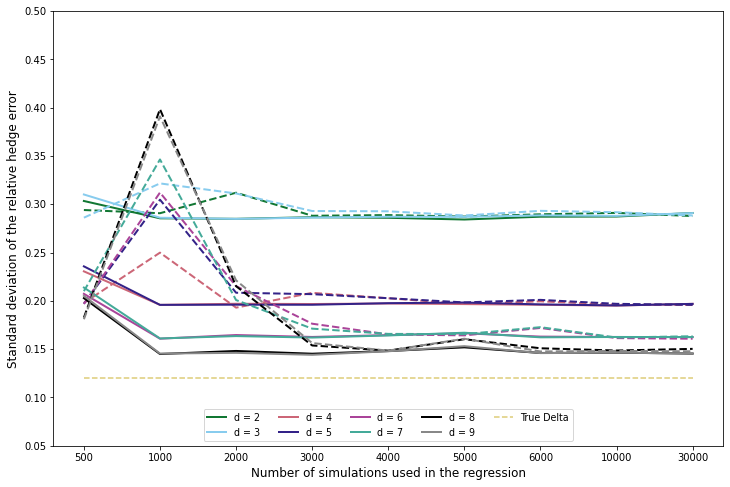

In [167]:
#Polynomial regression

sigma = 0.2
sigma0 = 0.2 
K = spot = 1 
T = 1
d = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
nSteps=52
nPaths= 1000
seed = np.random.randint(8192)
dt=T/nSteps
times=np.arange(0,T+0.01,dt)

L = np.array([500, 1000, 2000, 3000, 4000, 5000, 6000, 10000, 30000])

stdFinalBankBalanceMatrix=np.zeros([len(L),len(d)])
stdFinalBankBalanceMatrix_Diff=np.zeros([len(L),len(d)])
stockPath = pathsBachelier(T,K,sigma,nPaths,nSteps)
for j in range(0,len(d)):
    dim=d[j]
    stdFinalBankBalance = np.zeros(len(L))
    stdFinalBankBalance_Diff = np.zeros(len(L))
    for i in range(0,len(L)):
        nSim = L[i]
        s0=stockPath[:,0].reshape(nPaths, -1)
        if dim==0:
            z_pred = z_pred_Diff = Bachelier(s0, K, sigma, T, greek=1)
        else:
            x_train, y_train, z_train = GenerateDataBachelier(nSim, K, sigma, spot, sigma0, T, seed)
            z_pred = DifferentialRegression(dim,x_train.reshape(-1,1),y_train.reshape(-1,1),z_train.reshape(-1,1),s0, w=1)[2]
            z_pred_Diff = DifferentialRegression(dim,x_train.reshape(-1,1),y_train.reshape(-1,1),z_train.reshape(-1,1),s0, w=0.5)[2]
        stockQuantity = z_pred #delta, a
        stockQuantity_Diff = z_pred_Diff
        cost = stockQuantity*s0
        cost_Diff = stockQuantity_Diff*s0
        chargeToCustomer = Bachelier(s0, K, sigma, T-times[0], greek=0)
        bankBalance = chargeToCustomer - cost
        bankBalance_Diff = chargeToCustomer - cost_Diff
        #initialPrice = chargeToCustomer
        for t in range(1,nSteps):
            S = stockPath[:,t].reshape(nPaths, -1)
            timeToMaturity = T-times[t]
            #seed = np.random.randint(8192)
            if dim==0:
                z_pred = z_pred_Diff = Bachelier(S, K, sigma, timeToMaturity, greek=1)
            else:
                x_train, y_train, z_train = GenerateDataBachelier(nSim, K, sigma, spot, sigma0, timeToMaturity, seed) #BachelierTrainSet(S, nSim, seed, sigma, K, timeToMaturity) #BStrainSet(m, K, sigma, seed, timeToMaturity)
                z_pred = DifferentialRegression(dim,x_train.reshape(-1,1),y_train.reshape(-1,1),z_train.reshape(-1,1),S, w=1)[2] 
                z_pred_Diff = DifferentialRegression(dim,x_train.reshape(-1,1),y_train.reshape(-1,1),z_train.reshape(-1,1),S, w=0.5)[2] 
            #z_pred = Bachelier(S, K, sigma, timeToMaturity, greek=1) #BachelierDeltaCall(S, K, sigma, timeToMaturity) #BlackScholesDelta(s, K, sigma, timeToMaturity)
            newStockQuantity = z_pred
            newStockQuantity_Diff = z_pred_Diff
            amountToBuy = newStockQuantity-stockQuantity
            amountToBuy_Diff = newStockQuantity_Diff-stockQuantity_Diff
            cost = amountToBuy*S
            cost_Diff = amountToBuy_Diff*S
            bankBalance=bankBalance-cost
            bankBalance_Diff=bankBalance_Diff-cost_Diff
            stockQuantity = newStockQuantity
            stockQuantity_Diff = newStockQuantity_Diff
        S = stockPath[:,nSteps].reshape(nPaths, -1)
        stockValue = stockQuantity*S
        stockValue_Diff = stockQuantity_Diff*S
        liability = np.maximum(S-K,0)
        bankBalance = (bankBalance + stockValue - liability)
        bankBalance_Diff = (bankBalance_Diff + stockValue_Diff - liability)
        finalBankBalance = bankBalance
        finalBankBalance_Diff = bankBalance_Diff
        stdFinalBankBalance[i] = np.std(finalBankBalance)
        stdFinalBankBalance_Diff[i] = np.std(finalBankBalance_Diff)
    stdFinalBankBalanceMatrix[:,j]=stdFinalBankBalance/chargeToCustomer[0]
    stdFinalBankBalanceMatrix_Diff[:,j]=stdFinalBankBalance_Diff/chargeToCustomer[0]

L = [1, 2, 3, 4, 5, 6, 7, 8, 9]
labels = ['500','1000', '2000', '3000', '4000','5000','6000', '10000', '30000']

fig1, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(L, stdFinalBankBalanceMatrix[:,2],'--', linewidth = 2, color="#117733")
ax1.plot(L, stdFinalBankBalanceMatrix_Diff[:,2],'-',label = 'd = 2',linewidth = 2, color="#117733")
ax1.plot(L, stdFinalBankBalanceMatrix[:,3],'--',linewidth = 2, color="#88CCEE")
ax1.plot(L, stdFinalBankBalanceMatrix_Diff[:,3],'-',label = 'd = 3',linewidth = 2, color="#88CCEE")
ax1.plot(L, stdFinalBankBalanceMatrix[:,4],'--',linewidth = 2, color="#CC6677")
ax1.plot(L, stdFinalBankBalanceMatrix_Diff[:,4],'-',label = 'd = 4',linewidth = 2, color="#CC6677")
ax1.plot(L, stdFinalBankBalanceMatrix[:,5],'--',linewidth = 2, color="#332288")
ax1.plot(L, stdFinalBankBalanceMatrix_Diff[:,5],'-',label = 'd = 5',linewidth = 2, color="#332288")
ax1.plot(L, stdFinalBankBalanceMatrix[:,6],'--',linewidth = 2, color="#AA4499")
ax1.plot(L, stdFinalBankBalanceMatrix_Diff[:,6],'-',label = 'd = 6',linewidth = 2, color="#AA4499")
ax1.plot(L, stdFinalBankBalanceMatrix[:,7],'--',linewidth = 2, color="#44AA99")
ax1.plot(L, stdFinalBankBalanceMatrix_Diff[:,7],'-',label = 'd = 7',linewidth = 2, color="#44AA99")
ax1.plot(L, stdFinalBankBalanceMatrix[:,8],'--',linewidth = 2, color="black")
ax1.plot(L, stdFinalBankBalanceMatrix_Diff[:,8],'-',label = 'd = 8',linewidth = 2, color="black")
ax1.plot(L, stdFinalBankBalanceMatrix[:,9],'--',linewidth = 2, color="#888888")
ax1.plot(L, stdFinalBankBalanceMatrix_Diff[:,9],'-',label = 'd = 9',linewidth = 2, color="#888888")
ax1.plot(L, stdFinalBankBalanceMatrix[:,0],'--',linewidth = 1.5, label="True Delta", color="#DDCC77")
ax1.set_ylim(0.05,0.5)
ax1.set_xticks(L)
ax1.set_xticklabels(labels)
ax1.legend(
    loc="lower center", # "upper center" puts it below the line
    ncol=5,
    fontsize=9.5
)
ax1.set_xlabel('Number of simulations used in the regression',fontsize = 12)
ax1.set_ylabel('Standard deviation of the relative hedge error',fontsize = 12) #Normalised by the initial value of the hedge portfolio
#plt.savefig('ComparisonHedgeBachelierRegression')
plt.show(fig1)

### Discrete delta-hedging strategy for Black-Scholes

In [168]:
#Simulating stock path under Black-Scholes

def pathsBlackScholes(T,K,sigma,nPaths,nSteps):
    dt=T/nSteps
    np.random.randint(8192)
    pathsStock = np.zeros([nPaths,nSteps+1])
    s0 = K #+ sigma * np.sqrt(T) * np.random.normal(size=nPaths) #np.full(nPaths, 1.01)
    pathsStock[:,0] = s0
    for t in range(0,nSteps):
        pathsStock[:,t+1] = pathsStock[:,t] * np.exp((-0.5*sigma*sigma) * dt + sigma*np.sqrt(dt)*np.random.normal(size=nPaths))
    return pathsStock

In [ ]:
#Neural network
sigma = sigma0 = 0.2 
K = spot = 1 
T = 1
d = np.array([0, 2, 3, 4, 5, 6]) #np.array([0, 1, 2, 3, 4, 5])#, 6, 7, 8, 9]) #3
nSteps=52
nPaths= 1000
seed = np.random.randint(8192)
dt=T/nSteps
times=np.arange(0,T+0.01,dt) #overvej +0.01 hvis T=1 skal med 

def pathsBlackScholes(T,K,sigma,nPaths,nSteps):
    dt=T/nSteps
    np.random.randint(8192)
    pathsStock = np.zeros([nPaths,nSteps+1])
    s0 = K #+ sigma * np.sqrt(T) * np.random.normal(size=nPaths) #np.full(nPaths, 1.01)
    pathsStock[:,0] = s0
    for t in range(0,nSteps):
        pathsStock[:,t+1] = pathsStock[:,t] * np.exp((-0.5*sigma*sigma) * dt + sigma*np.sqrt(dt)*np.random.normal(size=nPaths))
    return pathsStock

L = np.array([500, 1000, 2000, 3000, 4000, 5000, 6000, 10000, 30000])

stdFinalBankBalanceMatrix=np.zeros([len(L),len(d)])
stdFinalBankBalanceMatrix_Diff=np.zeros([len(L),len(d)])
stockPath = pathsBlackScholes(T,K,sigma,nPaths,nSteps)
for j in range(0,len(d)):
    t0=time.time()
    dim=d[j]
    stdFinalBankBalance = np.zeros(len(L))
    stdFinalBankBalance_Diff = np.zeros(len(L))
    for i in range(0,len(L)):
        nSim = L[i]
        s0=stockPath[:,0].reshape(nPaths, -1)
        seed = np.random.randint(8192)
        if dim==0:
            z_pred = z_pred_Diff = BlackScholes(s0, K, sigma, T, greek=1)
        else:
            tf.keras.backend.clear_session()
            trainX, trainPY, trainDY = GenerateDataBlackScholes(nSim, K, sigma, spot, sigma0, T, seed)
            normX, meanX, stdX, normY, meanY, stdY = Normalization(trainX,trainPY,trainDY)           
            model_size = (dim,20) #the first input represents the number of layers and the second is the number of units
            model_diff = createNeuralNetwork(model_size[0],model_size[1],1)
            model_diff.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error',loss_weights = [0.5,0.5])
            model_diff.fit(normX, [normY[:,0],normY[:,1]], epochs = 100, batch_size = 1024, verbose = 0)
            z_pred_Diff = (model_diff.predict((s0 - meanX) / stdX)[1] * stdY[0] / stdX)
            tf.keras.backend.clear_session()
            model_ord = createNeuralNetwork(model_size[0],model_size[1],1)
            model_ord.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error',loss_weights = [1,0])
            model_ord.fit(normX, [normY[:,0],normY[:,1]], epochs = 100, batch_size = 1024, verbose = 0)
            z_pred = (model_ord.predict((s0 - meanX) / stdX)[1] * stdY[0] / stdX)
        stockQuantity = z_pred #delta, a
        stockQuantity_Diff = z_pred_Diff
        cost = stockQuantity*s0
        cost_Diff = stockQuantity_Diff*s0
        chargeToCustomer = BlackScholes(s0, K, sigma, T-times[0], greek=0)
        bankBalance = chargeToCustomer - cost
        bankBalance_Diff = chargeToCustomer - cost_Diff
        #initialPrice = chargeToCustomer
        for t in range(1,nSteps):
            S = stockPath[:,t].reshape(nPaths, -1)
            timeToMaturity = T-times[t]
            seed = np.random.randint(8192)
            if dim==0:
                z_pred = z_pred_Diff = BlackScholes(S, K, sigma, timeToMaturity, greek=1)
            else:
                tf.keras.backend.clear_session()
                trainX, trainPY, trainDY = GenerateDataBlackScholes(nSim, K, sigma, spot, sigma0, timeToMaturity, seed)
                normX, meanX, stdX, normY, meanY, stdY = Normalization(trainX,trainPY,trainDY)            
                model_size = (dim,20) #the first input represents the number of layers and the second is the number of units
                model_diff = createNeuralNetwork(model_size[0],model_size[1],1)
                model_diff.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error',loss_weights = [0.5,0.5])
                model_diff.fit(normX, [normY[:,0],normY[:,1]], epochs = 100, batch_size = 1024, verbose = 0)
                z_pred_Diff = (model_diff.predict((S - meanX) / stdX)[1] * stdY[0] / stdX)
                model_ord = createNeuralNetwork(model_size[0],model_size[1],1)
                model_ord.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error',loss_weights = [1,0])
                model_ord.fit(normX, [normY[:,0],normY[:,1]], epochs = 100, batch_size = 1024, verbose = 0)
                z_pred = (model_ord.predict((S - meanX) / stdX)[1] * stdY[0] / stdX)
            #z_pred = Bachelier(S, K, sigma, timeToMaturity, greek=1) #BachelierDeltaCall(S, K, sigma, timeToMaturity) #BlackScholesDelta(s, K, sigma, timeToMaturity)
            newStockQuantity = z_pred
            newStockQuantity_Diff = z_pred_Diff
            amountToBuy = newStockQuantity-stockQuantity
            amountToBuy_Diff = newStockQuantity_Diff-stockQuantity_Diff
            cost = amountToBuy*S
            cost_Diff = amountToBuy_Diff*S
            bankBalance=bankBalance-cost
            bankBalance_Diff=bankBalance_Diff-cost_Diff
            stockQuantity = newStockQuantity
            stockQuantity_Diff = newStockQuantity_Diff
        S = stockPath[:,nSteps].reshape(nPaths, -1)
        stockValue = stockQuantity*S
        stockValue_Diff = stockQuantity_Diff*S
        liability = np.maximum(S-K,0)
        bankBalance = (bankBalance + stockValue - liability)
        bankBalance_Diff = (bankBalance_Diff + stockValue_Diff - liability)
        finalBankBalance = bankBalance
        finalBankBalance_Diff = bankBalance_Diff
        stdFinalBankBalance[i] = np.std(finalBankBalance)
        stdFinalBankBalance_Diff[i] = np.std(finalBankBalance_Diff)
    stdFinalBankBalanceMatrix[:,j]=stdFinalBankBalance/chargeToCustomer[0]
    stdFinalBankBalanceMatrix_Diff[:,j]=stdFinalBankBalance_Diff/chargeToCustomer[0]
    t1=time.time()
    print("done",t1-t0)


In [ ]:
L = [1, 2, 3, 4, 5, 6, 7, 8, 9]
labels = ['500','1000', '2000', '3000', '4000','5000','6000', '10000', '30000']

fig1, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(L, stdFinalBankBalanceMatrix[:,1],'--', linewidth = 2, color="#117733")
ax1.plot(L, stdFinalBankBalanceMatrix_Diff[:,1],'-',label = 'depth = 2',linewidth = 2, color="#117733")
ax1.plot(L, stdFinalBankBalanceMatrix[:,2],'--',linewidth = 2, color="#88CCEE")
ax1.plot(L, stdFinalBankBalanceMatrix_Diff[:,2],'-',label = 'depth = 3',linewidth = 2, color="#88CCEE")
ax1.plot(L, stdFinalBankBalanceMatrix[:,3],'--',linewidth = 2, color="#CC6677")
ax1.plot(L, stdFinalBankBalanceMatrix_Diff[:,3],'-',label = 'depth = 4',linewidth = 2, color="#CC6677")
ax1.plot(L, stdFinalBankBalanceMatrix[:,4],'--',linewidth = 2, color="#332288")
ax1.plot(L, stdFinalBankBalanceMatrix_Diff[:,4],'-',label = 'depth = 5',linewidth = 2, color="#332288")
ax1.plot(L, stdFinalBankBalanceMatrix[:,5],'--',linewidth = 2, color="#AA4499")
ax1.plot(L, stdFinalBankBalanceMatrix_Diff[:,5],'-',label = 'depth = 6',linewidth = 2, color="#AA4499")
ax1.plot(L, stdFinalBankBalanceMatrix[:,0],'--',linewidth = 1.5, label="True Delta", color="#DDCC77")
#ax1.set_xlim(0,30500)
ax1.set_ylim(0.1,0.35) #2**a
ax1.set_xticks(L)
ax1.set_xticklabels(labels)
ax1.legend(
    loc="lower center", # "upper center" puts it below the line
    ncol=3,
    fontsize=9.5
)
ax1.set_xlabel('Number of simulations used in the neural network',fontsize = 12)
ax1.set_ylabel('Standard deviation of the relative hedge error',fontsize = 12)
#plt.savefig("NNComparisonBS.png")
plt.show()

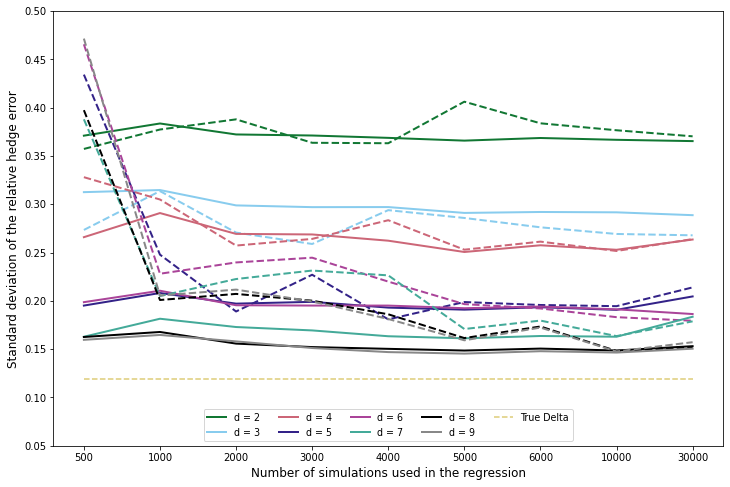

In [160]:
#Polynomial regression

sigma = sigma0 = 0.2 
K = spot = 1 
T = 1
d = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) 
nSteps=52
nPaths= 1000
seed = np.random.randint(8192)
dt=T/nSteps
times=np.arange(0,T+0.01,dt)  

stdFinalBankBalanceMatrix=np.zeros([9,len(d)])
stdFinalBankBalanceMatrix_Diff=np.zeros([9,len(d)])
stockPath = pathsBlackScholes(T,K,sigma,nPaths,nSteps)
for j in range(0,len(d)):
    dim=d[j]
    stdFinalBankBalance = np.zeros(9)
    stdFinalBankBalance_Diff = np.zeros(9)
    L = np.array([500, 1000, 2000, 3000, 4000, 5000, 6000, 10000, 30000])
    for i in range(0,len(L)):
        nSim = L[i]
        s0=stockPath[:,0].reshape(nPaths, -1)
        if dim==0:
            z_pred = z_pred_Diff = BlackScholes(s0, K, sigma, T, greek=1)
        else:
            x_train, y_train, z_train = GenerateDataBlackScholes(nSim, K, sigma, spot, sigma0, T, seed)
            z_pred = DifferentialRegression(dim,x_train.reshape(-1,1),y_train.reshape(-1,1),z_train.reshape(-1,1),s0, w=1)[2]
            z_pred_Diff = DifferentialRegression(dim,x_train.reshape(-1,1),y_train.reshape(-1,1),z_train.reshape(-1,1),s0, w=0.5)[2]
        #z_pred =  Bachelier(s0, K, sigma, T, greek=1) #BlackScholesDelta(s0, K, sigma, T)
        stockQuantity = z_pred #delta, a
        stockQuantity_Diff = z_pred_Diff
        cost = stockQuantity*s0
        cost_Diff = stockQuantity_Diff*s0
        chargeToCustomer = BlackScholes(s0, K, sigma, T-times[0], greek=0)
        bankBalance = chargeToCustomer - cost
        bankBalance_Diff = chargeToCustomer - cost_Diff
        #initialPrice = chargeToCustomer
        for t in range(1,nSteps):
            S = stockPath[:,t].reshape(nPaths, -1)
            timeToMaturity = T-times[t]
            #seed = np.random.randint(8192)
            if dim==0:
                z_pred = z_pred_Diff = BlackScholes(S, K, sigma, timeToMaturity, greek=1)
            else:
                x_train, y_train, z_train = GenerateDataBlackScholes(nSim, K, sigma, spot, sigma0, timeToMaturity, seed) #BachelierTrainSet(S, nSim, seed, sigma, K, timeToMaturity) #BStrainSet(m, K, sigma, seed, timeToMaturity)
                z_pred = DifferentialRegression(dim,x_train.reshape(-1,1),y_train.reshape(-1,1),z_train.reshape(-1,1),S, w=1)[2] 
                z_pred_Diff = DifferentialRegression(dim,x_train.reshape(-1,1),y_train.reshape(-1,1),z_train.reshape(-1,1),S, w=0.5)[2] 
            #z_pred = Bachelier(S, K, sigma, timeToMaturity, greek=1) #BachelierDeltaCall(S, K, sigma, timeToMaturity) #BlackScholesDelta(s, K, sigma, timeToMaturity)
            newStockQuantity = z_pred
            newStockQuantity_Diff = z_pred_Diff
            amountToBuy = newStockQuantity-stockQuantity
            amountToBuy_Diff = newStockQuantity_Diff-stockQuantity_Diff
            cost = amountToBuy*S
            cost_Diff = amountToBuy_Diff*S
            bankBalance=bankBalance-cost
            bankBalance_Diff=bankBalance_Diff-cost_Diff
            stockQuantity = newStockQuantity
            stockQuantity_Diff = newStockQuantity_Diff
        S = stockPath[:,nSteps].reshape(nPaths, -1)
        stockValue = stockQuantity*S
        stockValue_Diff = stockQuantity_Diff*S
        liability = np.maximum(S-K,0)
        bankBalance = (bankBalance + stockValue - liability)
        bankBalance_Diff = (bankBalance_Diff + stockValue_Diff - liability)
        finalBankBalance = bankBalance
        finalBankBalance_Diff = bankBalance_Diff
        stdFinalBankBalance[i] = np.std(finalBankBalance)
        stdFinalBankBalance_Diff[i] = np.std(finalBankBalance_Diff)
    stdFinalBankBalanceMatrix[:,j]=stdFinalBankBalance/chargeToCustomer[0]
    stdFinalBankBalanceMatrix_Diff[:,j]=stdFinalBankBalance_Diff/chargeToCustomer[0]

L = [1, 2, 3, 4, 5, 6, 7, 8, 9]
labels = ['500','1000', '2000', '3000', '4000','5000','6000', '10000', '30000']

fig1, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(L, stdFinalBankBalanceMatrix[:,2],'--',linewidth = 2, color="#117733")
ax1.plot(L, stdFinalBankBalanceMatrix_Diff[:,2],'-',label = 'd = 2',linewidth = 2, color="#117733")
ax1.plot(L, stdFinalBankBalanceMatrix[:,3],'--',linewidth = 2, color="#88CCEE")
ax1.plot(L, stdFinalBankBalanceMatrix_Diff[:,3],'-',label = 'd = 3',linewidth = 2, color="#88CCEE")
ax1.plot(L, stdFinalBankBalanceMatrix[:,4],'--',linewidth = 2, color="#CC6677")
ax1.plot(L, stdFinalBankBalanceMatrix_Diff[:,4],'-',label = 'd = 4',linewidth = 2, color="#CC6677")
ax1.plot(L, stdFinalBankBalanceMatrix[:,5],'--',linewidth = 2, color="#332288")
ax1.plot(L, stdFinalBankBalanceMatrix_Diff[:,5],'-',label = 'd = 5',linewidth = 2, color="#332288")
ax1.plot(L, stdFinalBankBalanceMatrix[:,6],'--',linewidth = 2, color="#AA4499")
ax1.plot(L, stdFinalBankBalanceMatrix_Diff[:,6],'-',label = 'd = 6',linewidth = 2, color="#AA4499")
ax1.plot(L, stdFinalBankBalanceMatrix[:,7],'--',linewidth = 2, color="#44AA99")
ax1.plot(L, stdFinalBankBalanceMatrix_Diff[:,7],'-',label = 'd = 7',linewidth = 2, color="#44AA99")
ax1.plot(L, stdFinalBankBalanceMatrix[:,8],'--',linewidth = 2, color="black")
ax1.plot(L, stdFinalBankBalanceMatrix_Diff[:,8],'-',label = 'd = 8',linewidth = 2, color="black")
ax1.plot(L, stdFinalBankBalanceMatrix[:,9],'--',linewidth = 2, color="#888888")
ax1.plot(L, stdFinalBankBalanceMatrix_Diff[:,9],'-',label = 'd = 9',linewidth = 2, color="#888888")
ax1.plot(L, stdFinalBankBalanceMatrix[:,0],'--',linewidth = 1.5, label="True Delta", color="#DDCC77")
#ax1.set_xlim(0,20500)
ax1.set_ylim(0.05,0.5)
ax1.legend(
    loc="lower center", # "upper center" puts it below the line
    ncol=5,
    fontsize=9.5
)
ax1.set_xticks(L)
ax1.set_xticklabels(labels)
ax1.set_xlabel('Number of simulations used in the regression',fontsize = 12)
ax1.set_ylabel('Standard deviation of the relative hedge error',fontsize = 12) #Normalised by the initial value of the hedge portfolio
#plt.savefig('ComparisonHedgeBlackScholesRegression')
plt.show()

### Hyperparameter search

In [118]:
#Test of performance for different NN architectures

def performanceNN(depth, width, sim):
  msePriceAll=np.zeros(sim)
  rmsePriceAll=np.zeros(sim)
  absPriceAll=np.zeros(sim)
  mseDeltaAll=np.zeros(sim)
  rmseDeltaAll=np.zeros(sim)
  absDeltaAll=np.zeros(sim)
  compAll=np.zeros(sim)
  valLossAll=np.zeros(sim)
  trainLossAll=np.zeros(sim)
  mseSampleAll=np.zeros(sim)
  for i in range(sim):
    tf.keras.backend.clear_session()
    TimeTMat = 0.1
    K = 1
    vol = 0.1
    seed=np.random.seed(2022)
    t0 = time.time()

    trainX, trainPY, trainDY = GenerateDataBachelier(1000, K, vol, K, vol, TimeTMat, seed)
    normX, meanX, stdX, normY, meanY, stdY = Normalization(trainX,trainPY,trainDY)
    seedTest=np.random.seed(1996)
    testX, testPY, testDY = GenerateDataBachelier(250, K, vol, K, vol, TimeTMat, seedTest)
    testY = np.column_stack((testPY,testDY))
    normTestX = (testX-meanX)/stdX
    normTestY = (testY-meanY)/stdY

    modelAnn = createNeuralNetwork(depth,width,1)
    modelAnn.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error',loss_weights = [0.5,0.5])
    t0 = time.time()
    history = modelAnn.fit(normX, [normY[:,0],normY[:,1]], epochs = 100, batch_size = 64, verbose = 0, validation_data = (normTestX, [normTestY[:,0],normTestY[:,1]]))
    t1 = time.time()
    comp = t1-t0

    xAxis = np.linspace(0.01, 1.80, 1000)
    truePrice =  Bachelier(xAxis, K, vol, TimeTMat, 0)
    predPrice = (modelAnn.predict((xAxis - meanX) / stdX)[0] * stdY[0] + meanY[0])[:,0]
    errorsPrice = (predPrice - truePrice)
    msePrice = np.mean(errorsPrice**2)
    rmsePrice = np.sqrt(msePrice)
    absPrice = mae(truePrice, predPrice)

    trueDelta =  Bachelier(xAxis, K, vol, TimeTMat, 1)
    predDelta = (modelAnn.predict((xAxis - meanX) / stdX)[1] * stdY[0] / stdX)[:,0]
    errorsDelta = (predDelta - trueDelta)
    mseDelta = np.mean(errorsDelta**2)
    rmseDelta = np.sqrt(mseDelta)
    absDelta = mae(trueDelta, predDelta)
    
    truePriceSample =  Bachelier(normX*stdX + meanX, K, vol, TimeTMat, 0)
    trueDeltaSample =  Bachelier(normX*stdX + meanX, K, vol, TimeTMat, 1)
    samplePayoff = normY[:,0]*stdY[0]+meanY[0]
    sampleDelta = normY[:,1]*stdY[1]+meanY[1]
    mseErrorSample = np.mean((samplePayoff - truePriceSample)**2)+np.mean((sampleDelta - trueDeltaSample)**2)

    msePriceAll[i]=msePrice
    rmsePriceAll[i]=rmsePrice
    absPriceAll[i]=absPrice
    mseDeltaAll[i]=mseDelta
    rmseDeltaAll[i]=rmseDelta
    absDeltaAll[i]=absDelta
    compAll[i]=comp
    valLossAll[i]=modelAnn.history.history['val_Price_output_loss'][-1]*(stdY[0]**2)+modelAnn.history.history['val_diff_layer_1_loss'][-1]*(stdY[1]**2)
    trainLossAll[i]=modelAnn.history.history['Price_output_loss'][-1]*(stdY[0]**2)+modelAnn.history.history['diff_layer_1_loss'][-1]*(stdY[1]**2)
    #valLossAll[i]=model_ann.history.history['val_loss'][-1]#*(stdY[0]**2)
    #trainLossAll[i]=model_ann.history.history['loss'][-1]#*(stdY[0]**2)
    mseSampleAll[i]=mseErrorSample
  return print(np.mean(msePriceAll), np.mean(rmsePriceAll), np.mean(absPriceAll), np.mean(mseDeltaAll), np.mean(rmseDeltaAll), np.mean(absDeltaAll), np.mean(compAll), np.mean(valLossAll), np.mean(trainLossAll), np.mean(mseSampleAll), modelAnn.count_params())

#Test performance of different architecture of neural networks by changing the two first inputs in the performanceNN function
#Futher, change the number in 'diff_layer_1_loss' such that it is one less than the number of layers given as the first input in performanceNN
performanceNN(2, 20, 100)


0.00019566945817833152 0.013988189953611995 0.010710935641048734 0.0015400600365426311 0.039243598669625485 0.03559567665957942 2.899076223373413 0.05617584948787779 0.053367906755223876 0.053165053054341466 481


In [ ]:
#Test for different batch sizes and learning rates 
TimeTMat = 0.1
K = 1
vol = 0.1
seed=np.random.seed(2022)

trainX, trainPY, trainDY = GenerateDataBachelier(30000, K, vol, K, vol, TimeTMat, seed)
normX, meanX, stdX, normY, meanY, stdY = Normalization(trainX,trainPY,trainDY)
sim=100
xAxis = np.linspace(0.01, 1.80, 1000)

learningrate = np.array([10**(-2),10**(-3),10**(-4),10**(-5),10**(-6)]) #np.array([10**(-2),10**(-3),10**(-4),10**(-5),10**(-6)])
batchsize = np.array([2**5,2**6,2**7,2**8,2**9,2**10,2**11])
msePriceAll=np.zeros((sim,len(batchsize)))
mseDeltaAll=np.zeros((sim,len(batchsize)))
msePriceMean=np.zeros((len(learningrate),len(batchsize)))
mseDeltaMean=np.zeros((len(learningrate),len(batchsize)))

for n in range(0,len(learningrate)):
    for b in range(0,len(batchsize)):
        for i in range(0,sim):
            tf.keras.backend.clear_session()
            modelAnn = createNeuralNetwork(4,20,1)
            modelAnn.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learningrate[n]), loss = 'mean_squared_error',loss_weights = [0.5,0.5]) 
            history = modelAnn.fit(normX, [normY[:,0],normY[:,1]], epochs = 100, batch_size = batchsize[b], verbose = 0)

            truePrice =  Bachelier(xAxis, K, vol, TimeTMat, 0)
            predPrice = (modelAnn.predict((xAxis - meanX) / stdX)[0] * stdY[0] + meanY[0])[:,0]
            errorsPrice = (predPrice - truePrice)
            msePrice = np.mean(errorsPrice**2)

            trueDelta =  Bachelier(xAxis, K, vol, TimeTMat, 1)
            predDelta = (modelAnn.predict((xAxis - meanX) / stdX)[1] * stdY[0] / stdX)[:,0]
            errorsDelta = (predDelta - trueDelta)
            mseDelta = np.mean(errorsDelta**2)
    
            msePriceAll[i,b]=msePrice
            mseDeltaAll[i,b]=mseDelta
        msePriceMean[n,b]=np.mean(msePriceAll,axis=0)[b]
        mseDeltaMean[n,b]=np.mean(mseDeltaAll,axis=0)[b]

In [ ]:
a = np.arange(5,12)
labels = ['$2^{{5}}$','$2^{{6}}$', '$2^{{7}}$', '$2^{{8}}$', '$2^{{9}}$','$2^{{10}}$','$2^{{11}}$'] #2**a

fig1, ax1 = plt.subplots(figsize=(7,5))
ax1.plot(a, msePriceMean[0,:],'-',linewidth = 2, label='$\eta=10^{{-2}}$',color="#117733")
ax1.plot(a, msePriceMean[1,:],'-',linewidth = 2, label='$\eta=10^{{-3}}$',color="#88CCEE")
ax1.plot(a, msePriceMean[2,:],'-',linewidth = 2, label='$\eta=10^{{-4}}$',color="#CC6677")
ax1.plot(a, msePriceMean[3,:],'-',linewidth = 2, label='$\eta=10^{{-5}}$',color="#332288")
ax1.plot(a, msePriceMean[4,:],'-',linewidth = 2, label='$\eta=10^{{-6}}$',color="#AA4499")
ax1.legend(title="Learning rate",
    loc="upper left",
    ncol=1,
    fontsize=9.5
)
ax1.xaxis.set_ticks(a) 
ax1.xaxis.set_ticklabels(labels) 
ax1.set_xlabel('Batch size',fontsize = 12)
ax1.set_ylabel('Price error (MSE)',fontsize = 12)
plt.show(fig1)

fig2, ax2 = plt.subplots(figsize=(7,5))
ax2.plot(a, msePriceMean[0,:],'-',linewidth = 2, label='$\eta=10^{{-2}}$',color="#117733")
ax2.plot(a, msePriceMean[1,:],'-',linewidth = 2, label='$\eta=10^{{-3}}$',color="#88CCEE")
ax2.plot(a, msePriceMean[2,:],'-',linewidth = 2, label='$\eta=10^{{-4}}$',color="#CC6677")
ax2.set_ylim(0.0,0.001)
ax2.legend(title="Learning rate",
    loc="upper left", 
    ncol=1,
    fontsize=9.5
)
ax2.xaxis.set_ticks(a) 
ax2.xaxis.set_ticklabels(labels) 
ax2.set_xlabel('Batch size',fontsize = 12)
ax2.set_ylabel('Price error (MSE)',fontsize = 12)
plt.show(fig2)

fig3, ax3 = plt.subplots(figsize=(7,5))
ax3.plot(a, mseDeltaMean[0,:],'-',linewidth = 2, label='$\eta=10^{{-2}}$',color="#117733")
ax3.plot(a, mseDeltaMean[1,:],'-',linewidth = 2, label='$\eta=10^{{-3}}$',color="#88CCEE")
ax3.plot(a, mseDeltaMean[2,:],'-',linewidth = 2, label='$\eta=10^{{-4}}$',color="#CC6677")
ax3.plot(a, mseDeltaMean[3,:],'-',linewidth = 2, label='$\eta=10^{{-5}}$',color="#332288")
ax3.plot(a, mseDeltaMean[4,:],'-',linewidth = 2, label='$\eta=10^{{-6}}$',color="#AA4499")
ax3.legend(title="Learning rate",
    loc="upper left",
    ncol=1,
    fontsize=9.5
)
ax3.xaxis.set_ticks(a)
ax3.xaxis.set_ticklabels(labels) 
ax3.set_xlabel('Batch size',fontsize = 12)
ax3.set_ylabel('Delta error (MSE)',fontsize = 12)
plt.show(fig3)

fig4, ax4 = plt.subplots(figsize=(7,5))
ax4.plot(a, mseDeltaMean[0,:],'-',linewidth = 2, label='$\eta=10^{{-2}}$',color="#117733")
ax4.plot(a, mseDeltaMean[1,:],'-',linewidth = 2, label='$\eta=10^{{-3}}$',color="#88CCEE")
ax4.plot(a, mseDeltaMean[2,:],'-',linewidth = 2, label='$\eta=10^{{-4}}$',color="#CC6677")
ax4.set_ylim(0.0,0.004)
ax4.legend(title="Learning rate",
    loc="upper left", 
    ncol=1,
    fontsize=9.5
)
ax4.xaxis.set_ticks(a) 
ax4.xaxis.set_ticklabels(labels) 
ax4.set_xlabel('Batch size',fontsize = 12)
ax4.set_ylabel('Delta error (MSE)',fontsize = 12)
plt.show(fig4)


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

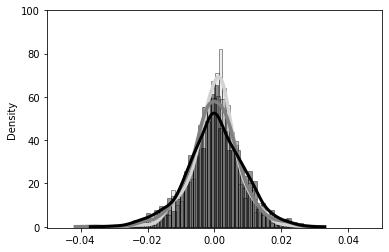

In [90]:
import seaborn as sns

fig, ax = plt.subplots()
sns.distplot(refB, hist=True, kde=True, 
             bins=int(45), color = 'lightgrey', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3.5})

sns.distplot(Diff, hist=True, kde=True, 
             bins=int(45), color = 'grey',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3.5})

sns.distplot(Ord, hist=True, kde=True, 
             bins=int(45), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})
ax.set_ylim(-0.5, 100)
ax.set_xlim(-0.05, 0.05)
plt.savefig('distBach100steps.png')
plt.show()

### Stress-testing the models

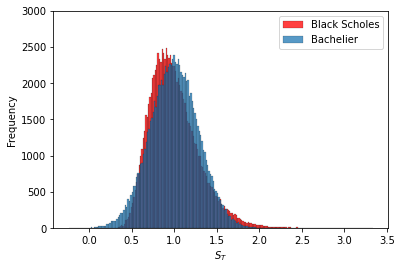

In [12]:
import seaborn as sns

seed=np.random.seed(1996)

def GenerateDataBlackScholes(nSim, K, sigma, spot, sigma0, T, seed): #T is time to maturity
    np.random.seed(seed)
    
    T0 = 1
    
    s0 = spot * np.exp((-0.5*sigma0*sigma0) * T0 + sigma0*np.sqrt(T0)*np.random.normal(size=nSim))
    sT = s0 * np.exp((-0.5*sigma*sigma) * T + sigma*np.sqrt(T)*np.random.normal(size=nSim))
    
    payoff = np.maximum(0, sT - K)
    deriv = np.where(sT > K, sT / s0, 0) 
    
    return s0, payoff, deriv, sT

def GenerateDataBachelier(nSim, K, sigma, spot, sigma0, T, seed): #T is time to maturity
    np.random.seed(seed)
    
    T0 = 1
    
    s0 = spot + sigma0 * np.sqrt(T0) * np.random.normal(size=nSim)
    sT = s0 + sigma * np.sqrt(T) * np.random.normal(size=nSim)
    
    payoff = np.maximum(0, sT - K)
    deriv = np.where(sT > K, 1, 0) 
    
    return s0, payoff, deriv, sT

s0, Y, DY, sT = GenerateDataBlackScholes(100000, 1, 0.2, 1, 0.2, 1, seed)
s0B, YB, DYB, sTB = GenerateDataBachelier(100000, 1, 0.2, 1, 0.2, 1, seed)

fig, ax = plt.subplots()
sns.histplot(x=sT, color='red', label='Black Scholes')
sns.histplot(x=sTB, label='Bachelier')
ax.set_xlabel('$S_T$')
ax.set_ylabel('Frequency')
ax.set_ylim(0,3000)
ax.legend(loc = 'upper right',fontsize = 10)
plt.savefig('HistBachelier.png')

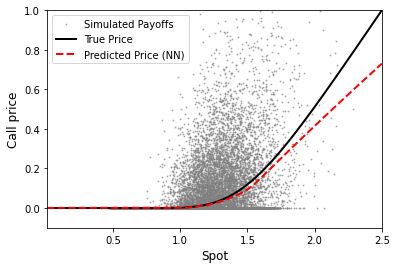

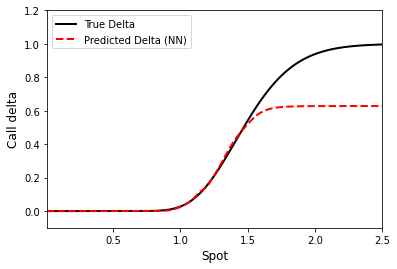

In [24]:
from matplotlib.pyplot import cm

TimeTMat = 1
K = 1.5
vol = 0.2
ModelArch = (4,20) #Note that "number of layers" represents both the hidden layers AND the output layer
seed = np.random.seed(2022)

t0 = time.time()

tf.keras.backend.clear_session()
#trainX, trainPY, trainDY = GenerateDataBlackScholes(nSim, K, vol, K, vol, TimeTMat, seed)
Y = np.maximum(0, sT - K)
DY = np.where(sT > K, sT / s0, 0) 
normX, meanX, stdX, normY, meanY, stdY = Normalization(s0,Y,DY)
xAxis = np.linspace(0.01, 2.5, 1000)

modelBS = createNeuralNetwork(ModelArch[0],ModelArch[1],1)
modelBS.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error',loss_weights = [0.5,0.5])
history = modelBS.fit(normX, [normY[:,0],normY[:,1]], epochs = 100, batch_size = 1024, verbose = 0)

truePrices = BlackScholes(xAxis, K, vol, TimeTMat, 0)
predPrices = (modelBS.predict((xAxis - meanX) / stdX)[0] * stdY[0] + meanY[0])
trueDelta = BlackScholes(xAxis, K, vol, TimeTMat, 1)
predDelta = (modelBS.predict((xAxis - meanX) / stdX)[1] * stdY[0] / stdX)

fig, ax = plt.subplots()
ax.set_xlim(0.01,2.5)
ax.set_ylim(-0.1,1.0) 
ax.plot(s0, Y,'o', markersize=1,label = "Simulated Payoffs",color = 'gray', alpha=0.5)
ax.plot(xAxis, truePrices, '-',label = 'True Price',linewidth = 2, color="black")
ax.plot(xAxis, predPrices, '--', label = 'Predicted Price (NN)', linewidth = 2,color = "red")
ax.legend(loc = 'upper left',fontsize = 10)
ax.set_xlabel('Spot',fontsize = 12)
ax.set_ylabel('Call price',fontsize = 12)
plt.savefig('BSHighStrikePrice.png')
plt.show(fig)

fig, ax = plt.subplots()
ax.set_xlim(0.01,2.5)
ax.set_ylim(-0.1,1.2)
ax.plot(xAxis, trueDelta, '-',label = 'True Delta',linewidth = 2, color="black")
ax.plot(xAxis, predDelta, '--', label = 'Predicted Delta (NN)', linewidth = 2,color = "red")
ax.legend(loc = 'upper left',fontsize = 10)
ax.set_xlabel('Spot',fontsize = 12)
ax.set_ylabel('Call delta',fontsize = 12)
plt.savefig('BSHighStrikeDelta.png')
plt.show(fig)

#plot_ModelVSTruePricesNN(modelBS, xAxis, K, vol, TimeTMat, model="BS")
#plot_ModelVSTrueDeltasNN(modelBS, xAxis, K, vol, TimeTMat, model="BS")            

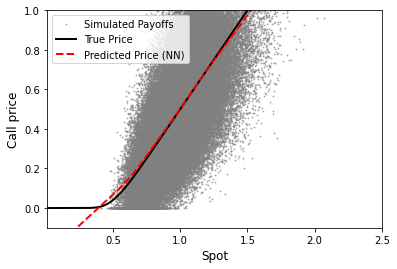

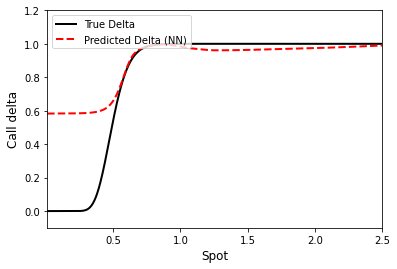

In [26]:
TimeTMat = 1
K = 0.50
vol = 0.2
ModelArch = (4,20) #Note that "number of layers" represents both the hidden layers AND the output layer
seed = np.random.seed(2022)

t0 = time.time()

tf.keras.backend.clear_session()
#trainX, trainPY, trainDY = GenerateDataBlackScholes(nSim, K, vol, K, vol, TimeTMat, seed)
Y = np.maximum(0, sT - K)
DY = np.where(sT > K, sT / s0, 0) 
normX, meanX, stdX, normY, meanY, stdY = Normalization(s0,Y,DY)
xAxis = np.linspace(0.01, 2.5, 1000)

modelBS = createNeuralNetwork(ModelArch[0],ModelArch[1],1)
modelBS.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error',loss_weights = [0.5,0.5])
history = modelBS.fit(normX, [normY[:,0],normY[:,1]], epochs = 100, batch_size = 1024, verbose = 0)

truePrices = BlackScholes(xAxis, K, vol, TimeTMat, 0)
predPrices = (modelBS.predict((xAxis - meanX) / stdX)[0] * stdY[0] + meanY[0])
trueDelta = BlackScholes(xAxis, K, vol, TimeTMat, 1)
predDelta = (modelBS.predict((xAxis - meanX) / stdX)[1] * stdY[0] / stdX)

fig, ax = plt.subplots()
ax.set_xlim(0.01,2.5)
ax.set_ylim(-0.1,1) 
ax.plot(s0, Y,'o', markersize=1,label = "Simulated Payoffs",color = 'gray', alpha=0.5)
ax.plot(xAxis, truePrices, '-',label = 'True Price',linewidth = 2, color="black")
ax.plot(xAxis, predPrices, '--', label = 'Predicted Price (NN)', linewidth = 2,color = "red")
ax.legend(loc = 'upper left',fontsize = 10)
ax.set_xlabel('Spot',fontsize = 12)
ax.set_ylabel('Call price',fontsize = 12)
plt.savefig('BSLowStrikePrice.png')
plt.show(fig)

fig, ax = plt.subplots()
ax.set_xlim(0.01,2.5)
ax.set_ylim(-0.1,1.2)
ax.plot(xAxis, trueDelta, '-',label = 'True Delta',linewidth = 2, color="black")
ax.plot(xAxis, predDelta, '--', label = 'Predicted Delta (NN)', linewidth = 2,color = "red")
ax.legend(loc = 'upper left',fontsize = 10)
ax.set_xlabel('Spot',fontsize = 12)
ax.set_ylabel('Call delta',fontsize = 12)
plt.savefig('BSLowStrikeDelta.png')
plt.show(fig)

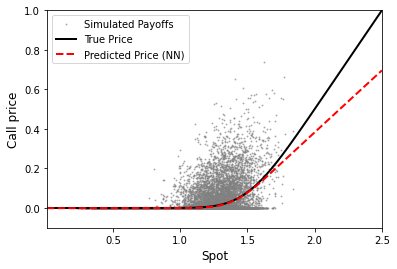

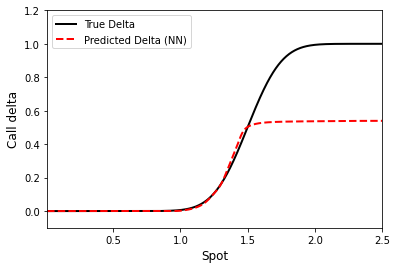

In [27]:
from matplotlib.pyplot import cm

TimeTMat = 1
K = 1.50
vol = 0.2
ModelArch = (4,20)
seed = np.random.seed(2022)

tf.keras.backend.clear_session()
#trainX, trainPY, trainDY = GenerateDataBlackScholes(nSim, K, vol, K, vol, TimeTMat, seed)
YB = np.maximum(0, sTB - K)
DYB = np.where(sTB > K, 1, 0) 
normX, meanX, stdX, normY, meanY, stdY = Normalization(s0B,YB,DYB)
xAxis = np.linspace(0.01, 2.50, 1000)

modelB = createNeuralNetwork(ModelArch[0],ModelArch[1],1)
modelB.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error',loss_weights = [0.3,0.7])
history = modelB.fit(normX, [normY[:,0],normY[:,1]], epochs = 100, batch_size = 1024, verbose = 0)

truePrices = Bachelier(xAxis, K, vol, TimeTMat, 0)
predPrices = (modelB.predict((xAxis - meanX) / stdX)[0] * stdY[0] + meanY[0])
trueDelta = Bachelier(xAxis, K, vol, TimeTMat, 1)
predDelta = (modelB.predict((xAxis - meanX) / stdX)[1] * stdY[0] / stdX)

fig, ax = plt.subplots()
ax.set_xlim(0.01,2.5)
ax.set_ylim(-0.1,1.0) 
ax.plot(s0B, YB,'o', markersize=1,label = "Simulated Payoffs",color = 'gray', alpha=0.5)
ax.plot(xAxis, truePrices, '-',label = 'True Price',linewidth = 2, color="black")
ax.plot(xAxis, predPrices, '--', label = 'Predicted Price (NN)', linewidth = 2,color = "red")
ax.legend(loc = 'upper left',fontsize = 10)
ax.set_xlabel('Spot',fontsize = 12)
ax.set_ylabel('Call price',fontsize = 12)
plt.savefig('BHighStrikePrice.png')
plt.show(fig)  

fig, ax = plt.subplots()
ax.set_xlim(0.01,2.5)
ax.set_ylim(-0.1,1.2)
ax.plot(xAxis, trueDelta, '-',label = 'True Delta',linewidth = 2, color="black")
ax.plot(xAxis, predDelta, '--', label = 'Predicted Delta (NN)', linewidth = 2,color = "red")
ax.legend(loc = 'upper left',fontsize = 10)
ax.set_xlabel('Spot',fontsize = 12)
ax.set_ylabel('Call delta',fontsize = 12)
plt.savefig('BHighStrikeDelta.png')
plt.show(fig)

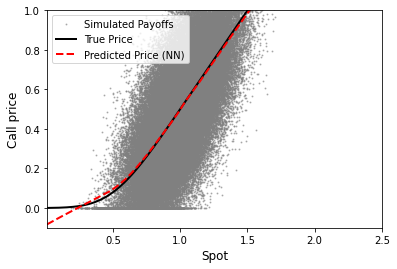

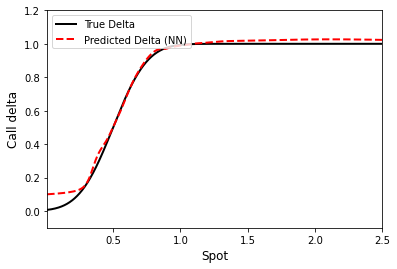

In [29]:
from matplotlib.pyplot import cm

TimeTMat = 1
K = 0.5
vol = 0.2
ModelArch = (5,20) #Note that "number of layers" represents both the hidden layers AND the output layer
nSim = 30000
seed = np.random.seed(2022)

t0 = time.time()

tf.keras.backend.clear_session()
#trainX, trainPY, trainDY = GenerateDataBlackScholes(nSim, K, vol, K, vol, TimeTMat, seed)
YB = np.maximum(0, sTB - K)
DYB = np.where(sTB > K, 1, 0)
normX, meanX, stdX, normY, meanY, stdY = Normalization(s0B,YB,DYB)
xAxis = np.linspace(0.01, 2.50, 1000)

modelB = createNeuralNetwork(ModelArch[0],ModelArch[1],1)
modelB.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error',loss_weights = [0.3,0.7])
history = modelB.fit(normX, [normY[:,0],normY[:,1]], epochs = 100, batch_size = 1024, verbose = 0)

truePrices = Bachelier(xAxis, K, vol, TimeTMat, 0)
predPrices = (modelB.predict((xAxis - meanX) / stdX)[0] * stdY[0] + meanY[0])
trueDelta = Bachelier(xAxis, K, vol, TimeTMat, 1)
predDelta = (modelB.predict((xAxis - meanX) / stdX)[1] * stdY[0] / stdX)

fig, ax = plt.subplots()
ax.set_xlim(0.01,2.5)
ax.set_ylim(-0.1,1.0) 
ax.plot(s0B, YB,'o', markersize=1,label = "Simulated Payoffs",color = 'gray', alpha=0.5)
ax.plot(xAxis, truePrices, '-',label = 'True Price',linewidth = 2, color="black")
ax.plot(xAxis, predPrices, '--', label = 'Predicted Price (NN)', linewidth = 2,color = "red")
ax.legend(loc = 'upper left',fontsize = 10)
ax.set_xlabel('Spot',fontsize = 12)
ax.set_ylabel('Call price',fontsize = 12)
plt.savefig('BLowStrikePrice.png')
plt.show(fig)  

fig, ax = plt.subplots()
ax.set_xlim(0.01,2.5)
ax.set_ylim(-0.1,1.2)
ax.plot(xAxis, trueDelta, '-',label = 'True Delta',linewidth = 2, color="black")
ax.plot(xAxis, predDelta, '--', label = 'Predicted Delta (NN)', linewidth = 2,color = "red")
ax.legend(loc = 'upper left',fontsize = 10)
ax.set_xlabel('Spot',fontsize = 12)
ax.set_ylabel('Call delta',fontsize = 12)
plt.savefig('BLowStrikeDelta.png')
plt.show(fig)

In [15]:
def pathsBachelier(T,K,sigma,nPaths,nSteps):
    dt=T/nSteps
    np.random.randint(8192)
    pathsStock = np.zeros([nPaths,nSteps+1])
    s0 = K #+ sigma * np.sqrt(T) * np.random.normal(size=nPaths) #np.full(nPaths, 1.01)
    pathsStock[:,0] = s0
    for t in range(0,nSteps):
        pathsStock[:,t+1] = pathsStock[:,t] + sigma * np.sqrt(dt) * np.random.normal(size=nPaths)
    return pathsStock

stockPath = pathsBachelier(1,1,0.2,1000,52)
print(stockPath)

[[1.         0.95249697 0.94164588 ... 0.82688876 0.83308868 0.82390442]
 [1.         0.96374681 0.92716347 ... 0.77823886 0.79554119 0.84907224]
 [1.         0.99436265 0.94081803 ... 1.09815371 1.10787861 1.12442832]
 ...
 [1.         0.98863922 1.01732693 ... 0.86095619 0.82697153 0.85397024]
 [1.         1.04838702 1.01831621 ... 0.74494591 0.71193215 0.69776059]
 [1.         0.94083233 0.94738129 ... 0.74777397 0.72932607 0.72255077]]


In [17]:
#Testing different volatilities sigma_0

sigma0 = 0.6
sigma = 0.2
K = spot = 1 #110
T = 0.1
d = np.array([0,4]) #np.array([0, 1, 2, 3, 4, 5])#, 6, 7, 8, 9]) #3
nSteps=52
nPaths= 1000
seed = np.random.randint(8192)
dt=T/nSteps
times=np.arange(0,T+0.01,dt) #overvej +0.01 hvis T=1 skal med 

L = np.array([30000])

meanFinalBankBalanceMatrix_Diff=np.zeros([len(L),len(d)])
stdFinalBankBalanceMatrix_Diff=np.zeros([len(L),len(d)])
for j in range(0,len(d)):
    t0=time.time()
    dim=d[j]
    stdFinalBankBalance_Diff = np.zeros(len(L))
    meanFinalBankBalance_Diff = np.zeros(len(L))
    for i in range(0,len(L)):
        nSim = L[i]
        s0=stockPath[:,0].reshape(nPaths, -1)
        seed = np.random.randint(8192)
        if dim==0:
            z_pred_Diff = Bachelier(s0, K, sigma, T, greek=1)
        else:
            tf.keras.backend.clear_session()
            trainX, trainPY, trainDY = GenerateDataBachelier(nSim, K, sigma, spot, sigma0, T, seed)
            normX, meanX, stdX, normY, meanY, stdY = Normalization(trainX,trainPY,trainDY)
            dif_weight=0.3            
            model_size = (dim,20) #the first input represents the number of layers and the second is the number of units
            model_diff = createNeuralNetwork(model_size[0],model_size[1],1)
            model_diff.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error',loss_weights = [dif_weight,(1-dif_weight)])
            model_diff.fit(normX, [normY[:,0],normY[:,1]], epochs = 100, batch_size = 1024, verbose = 0)
            z_pred_Diff = (model_diff.predict((s0 - meanX) / stdX)[1] * stdY[0] / stdX)
        stockQuantity_Diff = z_pred_Diff
        cost_Diff = stockQuantity_Diff*s0
        chargeToCustomer = Bachelier(s0, K, sigma, T-times[0], greek=0)
        bankBalance_Diff = chargeToCustomer - cost_Diff
        #initialPrice = chargeToCustomer
        for t in range(1,nSteps):
            S = stockPath[:,t].reshape(nPaths, -1)
            timeToMaturity = T-times[t]
            seed = np.random.randint(8192)
            if dim==0:
                z_pred_Diff = Bachelier(S, K, sigma, timeToMaturity, greek=1)
            else:
                tf.keras.backend.clear_session()
                trainX, trainPY, trainDY = GenerateDataBachelier(nSim, K, sigma, spot, sigma0, timeToMaturity, seed)
                normX, meanX, stdX, normY, meanY, stdY = Normalization(trainX,trainPY,trainDY)
                lambda_cal = 1.0 / np.sqrt((normY[:,1] ** 2).mean(axis=0))
                dif_weight=0.3             
                model_size = (dim,20) #the first input represents the number of layers and the second is the number of units
                model_diff = createNeuralNetwork(model_size[0],model_size[1],1)
                model_diff.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error',loss_weights = [dif_weight,(1-dif_weight)])
                model_diff.fit(normX, [normY[:,0],normY[:,1]], epochs = 100, batch_size = 1024, verbose = 0)
                z_pred_Diff = (model_diff.predict((S - meanX) / stdX)[1] * stdY[0] / stdX)
           #z_pred = Bachelier(S, K, sigma, timeToMaturity, greek=1) #BachelierDeltaCall(S, K, sigma, timeToMaturity) #BlackScholesDelta(s, K, sigma, timeToMaturity)
            newStockQuantity_Diff = z_pred_Diff
            amountToBuy_Diff = newStockQuantity_Diff-stockQuantity_Diff
            cost_Diff = amountToBuy_Diff*S
            bankBalance_Diff=bankBalance_Diff-cost_Diff
            stockQuantity_Diff = newStockQuantity_Diff
        S = stockPath[:,nSteps].reshape(nPaths, -1)
        stockValue_Diff = stockQuantity_Diff*S
        liability = np.maximum(S-K,0)
        bankBalance_Diff = (bankBalance_Diff + stockValue_Diff - liability)
        finalBankBalance_Diff = bankBalance_Diff
        stdFinalBankBalance_Diff[i] = np.std(finalBankBalance_Diff)
        meanFinalBankBalance_Diff[i] = np.mean(finalBankBalance_Diff)
    meanFinalBankBalanceMatrix_Diff[:,j] = meanFinalBankBalance_Diff /chargeToCustomer[0]
    stdFinalBankBalanceMatrix_Diff[:,j]=stdFinalBankBalance_Diff /chargeToCustomer[0]
    t1=time.time()
    print("done",t1-t0)

print(stdFinalBankBalanceMatrix_Diff)
print(meanFinalBankBalanceMatrix_Diff)

done 0.04313492774963379
done 617.5387060642242
[[1.31555026 1.28276634]]
[[-2.16934959 -2.15609471]]


In [19]:
def pathsBlackScholes(T,K,sigma,nPaths,nSteps):
    dt=T/nSteps
    np.random.randint(8192)
    pathsStock = np.zeros([nPaths,nSteps+1])
    s0 = K #+ sigma * np.sqrt(T) * np.random.normal(size=nPaths) #np.full(nPaths, 1.01)
    pathsStock[:,0] = s0
    for t in range(0,nSteps):
        pathsStock[:,t+1] = pathsStock[:,t] * np.exp((-0.5*sigma*sigma) * dt + sigma*np.sqrt(dt)*np.random.normal(size=nPaths))
    return pathsStock

stockPath = pathsBlackScholes(1,1,0.2,1000,52)
print(stockPath)

[[1.         0.97492919 0.95304465 ... 0.89107937 0.89330672 0.89074566]
 [1.         0.95928072 0.95937838 ... 1.01319478 1.07534245 1.07248309]
 [1.         1.01940596 1.00210426 ... 1.28241716 1.239589   1.22964147]
 ...
 [1.         0.97385593 0.991938   ... 0.95456195 0.93446649 0.92546273]
 [1.         1.0006063  1.03770532 ... 0.98105609 0.9844959  0.9901976 ]
 [1.         1.03707732 1.06912117 ... 1.43845125 1.48295142 1.46598142]]


In [23]:
sigma0 = 0.1
sigma = 0.2
K = spot = 1 
T = 1
d = np.array([0,4]) 
nSteps=52
nPaths= 1000
seed = np.random.randint(8192)
dt=T/nSteps
times=np.arange(0,T+0.01,dt) #overvej +0.01 hvis T=1 skal med 

L = np.array([30000])

stdFinalBankBalanceMatrix=np.zeros([len(L),len(d)])
stdFinalBankBalanceMatrix_Diff=np.zeros([len(L),len(d)])
for j in range(0,len(d)):
    t0=time.time()
    dim=d[j]
    stdFinalBankBalance = np.zeros(len(L))
    stdFinalBankBalance_Diff = np.zeros(len(L))
    for i in range(0,len(L)):
        nSim = L[i]
        s0=stockPath[:,0].reshape(nPaths, -1)
        seed = np.random.randint(8192)
        if dim==0:
            z_pred = z_pred_Diff = BlackScholes(s0, K, sigma, T, greek=1)
        else:
            tf.keras.backend.clear_session()
            trainX, trainPY, trainDY = GenerateDataBlackScholes(nSim, K, sigma, spot, sigma0, T, seed)
            normX, meanX, stdX, normY, meanY, stdY = Normalization(trainX,trainPY,trainDY)           
            model_size = (dim,20) #the first input represents the number of layers and the second is the number of units
            model_diff = createNeuralNetwork(model_size[0],model_size[1],1)
            model_diff.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error',loss_weights = [0.5,0.5])
            model_diff.fit(normX, [normY[:,0],normY[:,1]], epochs = 100, batch_size = 1024, verbose = 0)
            z_pred_Diff = (model_diff.predict((s0 - meanX) / stdX)[1] * stdY[0] / stdX)
            tf.keras.backend.clear_session()
            model_ord = createNeuralNetwork(model_size[0],model_size[1],1)
            model_ord.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error',loss_weights = [1,0])
            model_ord.fit(normX, [normY[:,0],normY[:,1]], epochs = 100, batch_size = 1024, verbose = 0)
            z_pred = (model_ord.predict((s0 - meanX) / stdX)[1] * stdY[0] / stdX)
        stockQuantity = z_pred #delta, a
        stockQuantity_Diff = z_pred_Diff
        cost = stockQuantity*s0
        cost_Diff = stockQuantity_Diff*s0
        chargeToCustomer = BlackScholes(s0, K, sigma, T-times[0], greek=0)
        bankBalance = chargeToCustomer - cost
        bankBalance_Diff = chargeToCustomer - cost_Diff
        #initialPrice = chargeToCustomer
        for t in range(1,nSteps):
            S = stockPath[:,t].reshape(nPaths, -1)
            timeToMaturity = T-times[t]
            seed = np.random.randint(8192)
            if dim==0:
                z_pred = z_pred_Diff = BlackScholes(S, K, sigma, timeToMaturity, greek=1)
            else:
                tf.keras.backend.clear_session()
                trainX, trainPY, trainDY = GenerateDataBlackScholes(nSim, K, sigma, spot, sigma0, timeToMaturity, seed)
                normX, meanX, stdX, normY, meanY, stdY = Normalization(trainX,trainPY,trainDY)            
                model_size = (dim,20) #the first input represents the number of layers and the second is the number of units
                model_diff = createNeuralNetwork(model_size[0],model_size[1],1)
                model_diff.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error',loss_weights = [0.5,0.5])
                model_diff.fit(normX, [normY[:,0],normY[:,1]], epochs = 100, batch_size = 1024, verbose = 0)
                z_pred_Diff = (model_diff.predict((S - meanX) / stdX)[1] * stdY[0] / stdX)
                model_ord = createNeuralNetwork(model_size[0],model_size[1],1)
                model_ord.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error',loss_weights = [1,0])
                model_ord.fit(normX, [normY[:,0],normY[:,1]], epochs = 100, batch_size = 1024, verbose = 0)
                z_pred = (model_ord.predict((S - meanX) / stdX)[1] * stdY[0] / stdX)
            #z_pred = Bachelier(S, K, sigma, timeToMaturity, greek=1) #BachelierDeltaCall(S, K, sigma, timeToMaturity) #BlackScholesDelta(s, K, sigma, timeToMaturity)
            newStockQuantity = z_pred
            newStockQuantity_Diff = z_pred_Diff
            amountToBuy = newStockQuantity-stockQuantity
            amountToBuy_Diff = newStockQuantity_Diff-stockQuantity_Diff
            cost = amountToBuy*S
            cost_Diff = amountToBuy_Diff*S
            bankBalance=bankBalance-cost
            bankBalance_Diff=bankBalance_Diff-cost_Diff
            stockQuantity = newStockQuantity
            stockQuantity_Diff = newStockQuantity_Diff
        S = stockPath[:,nSteps].reshape(nPaths, -1)
        stockValue = stockQuantity*S
        stockValue_Diff = stockQuantity_Diff*S
        liability = np.maximum(S-K,0)
        bankBalance = (bankBalance + stockValue - liability)
        bankBalance_Diff = (bankBalance_Diff + stockValue_Diff - liability)
        finalBankBalance = bankBalance
        finalBankBalance_Diff = bankBalance_Diff
        stdFinalBankBalance[i] = np.std(finalBankBalance)
        stdFinalBankBalance_Diff[i] = np.std(finalBankBalance_Diff)
    stdFinalBankBalanceMatrix[:,j]=stdFinalBankBalance/chargeToCustomer[0]
    stdFinalBankBalanceMatrix_Diff[:,j]=stdFinalBankBalance_Diff/chargeToCustomer[0]
    t1=time.time()
    print("done",t1-t0)

print(stdFinalBankBalanceMatrix_Diff)

done 0.025479793548583984
done 1062.3411011695862
[[0.1259139  0.13329843]]


In [ ]:
#  We will assume the 50 strike call
def ReLU(x):
    return x * (x > 0)

#  These are needed for the Black-Schole model, but these values are unimportant as we are setting time to zero
r = 0
sigma = 0.1

#  Days to expiration.  We are interested in the call's value at expiration.
t = 0.1

#  Strike Price
K = 1

#  We are assuming we paid a debit of this much for the call
C0 = 0

#  Generate a range of stock prices for plotting.  There will be issues with this is S is exactly equal to K.
S = np.linspace(0, 2, 1000)
Payoff = S-K

#  Calculate the call price as a function of S
C=ReLU(Payoff)


#  Plot the payout graph

fig, ax = plt.subplots()
ax.plot(S, C,linewidth = 2, color="black") 
ax.set_xlabel('$S_T$', loc="right")
#ax.set_xlabel('K', loc="center")
ax.set_ylabel('$C_T$', loc="top", rotation='horizontal')
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.savefig('CallFunction.png')
plt.show(fig)